# **SentimentArcs (Part 4): DNN to Transformer Models**

```
Jon Chun
12 Jun 2021: Started
04 Mar 2022: Last Update
```

In [2]:
# Make sure using a GPU

# Tesla V100 = (3.0 x) P100 (2 vCPUs)
#       P100 = (1.6 x) K80  (2 vCPUs/12GB RAM)
#       P100 ~ T4 
#       K80  = (     ) NVIDA GeForce RTX 3080 Ti
#
# High RAM Colab Pro  32GB RAM     $9.99/mo
#          Colab Pro+ 52GB        $49.95/mo

# Paperspace Free & Paid JupyterLab vs Google Colab
# https://blog.paperspace.com/alternative-to-google-colab-pro/#:~:text=Most%20notable%20is%20that%20the,and%2012%20GB%20of%20RAM.&text=Meanwhile%2C%20in%20Paperspace%20Gradient%2C%20GPU,a%20Free%20or%20Paid%20instance. 
# https://www.kaggle.com/general/198232
# https://towardsdatascience.com/deep-learning-on-a-budget-450-egpu-vs-google-colab-494f9a2ff0db (3080 vs Colab)
# https://towardsdatascience.com/when-to-use-cpus-vs-gpus-vs-tpus-in-a-kaggle-competition-9af708a8c3eb (Kaggle Comp)
# https://towardsdatascience.com/google-colab-pro-is-it-worth-49-99-c542770b8e56 (Colab Pro+)
# https://www.quora.com/Which-is-better-Google-Colab-or-Kaggle-Notebook (Kaggle vs Colab GPUs)

!nvidia-smi

Tue Apr 12 12:50:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **[RESTART RUNTIME] May be Required for these Libaries**

# **[STEP 1] Manual Configuration/Setup**



In [3]:
!pip install transformers[sentencepiece]

     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |████████████████████████████████| 77 kB 8.8 MB/s 
     |████████████████████████████████| 895 kB 61.3 MB/s 
     |████████████████████████████████| 596 kB 64.1 MB/s 
     |████████████████████████████████| 6.5 MB 47.5 MB/s 
     |████████████████████████████████| 1.2 MB 59.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## (Popups) Connect Google gDrive

In [4]:
# [INPUT REQUIRED]: Authorize access to Google gDrive

# Connect this Notebook to your permanent Google Drive
#   so all generated output is saved to permanent storage there

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("Attempting to attach your Google gDrive to this Colab Jupyter Notebook")
  drive.mount('/gdrive')
else:
  print("Your Google gDrive is attached to this Colab Jupyter Notebook")

Attempting to attach your Google gDrive to this Colab Jupyter Notebook
Mounted at /gdrive


## (3 Inputs) Define Directory Tree

In [6]:
# [CUSTOMIZE]: Change the text after the Unix '%cd ' command below (change directory)
#              to math the full path to your gDrive subdirectory which should be the 
#              root directory cloned from the SentimentArcs github repo.

# NOTE: Make sure this subdirectory already exists and there are 
#       no typos, spaces or illegals characters (e.g. periods) in the full path after %cd

# NOTE: In Python all strings must begin with an upper or lowercase letter, and only
#         letter, number and underscores ('_') characters should appear afterwards.
#         Make sure your full path after %cd obeys this constraint or errors may appear.

# #@markdown **Instructions**

# #@markdown Set Directory and Corpus names:
# #@markdown <li> Set <b>Path_to_SentimentArcs</b> to the project root in your **GDrive folder**
# #@markdown <li> Set <b>Corpus_Genre</b> = [novels, finance, social_media]
# #@markdown <li> <b>Corpus_Type</b> = [reference_corpus, new_corpus]
# #@markdown <li> <b>Corpus_Number</b> = [1-20] (id nunmber if a new_corpus)

#@markdown <hr>

# Step #1: Get full path to SentimentArcs subdir on gDrive
# =======
#@markdown **Accept default path on gDrive or Enter new one:**

Path_to_SentimentArcs = "/gdrive/MyDrive/sentimentarcs_notebooks/" #@param ["/gdrive/MyDrive/sentiment_arcs/"] {allow-input: true}


#@markdown Set this to the project root in your <b>GDrive folder</b>
#@markdown <br> (e.g. /<wbr><b>gdrive/MyDrive/research/sentiment_arcs/</b>)

#@markdown <hr>

#@markdown **Which type of texts are you cleaning?** \

Corpus_Genre = "novels" #@param ["novels", "social_media", "finance"]

# Corpus_Type = "reference" #@param ["new", "reference"]
Corpus_Type = "new" #@param ["new", "reference"]


Corpus_Number = 2 #@param {type:"slider", min:0, max:10, step:1}


#@markdown Put in the corresponding Subdirectory under **./text_raw**:
#@markdown <li> All Texts as clean <b>plaintext *.txt</b> files 
#@markdown <li> A <b>YAML Configuration File</b> describing each Texts

#@markdown Please verify the required textfiles and YAML file exist in the correct subdirectories before continuing.

print('Current Working Directory:')
%cd $Path_to_SentimentArcs

print('\n')

if Corpus_Type == 'reference':
  SUBDIR_SENTIMENT_RAW = f'sentiment_raw_{Corpus_Genre}_reference'
  SUBDIR_TEXT_CLEAN = f'text_clean_{Corpus_Genre}_reference'
else:
  SUBDIR_SENTIMENT_RAW = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}/'
  SUBDIR_TEXT_CLEAN = f'text_clean_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}/'

# PATH_SENTIMENT_RAW = f'./sentiment_raw/{SUBDIR_TEXT_RAW}'
# PATH_TEXT_CLEAN = f'./text_clean/{SUBDIR_TEXT_CLEAN}'
PATH_SENTIMENT_RAW = f'./sentiment_raw/{SUBDIR_SENTIMENT_RAW}'
PATH_TEXT_CLEAN = f'./text_clean/{SUBDIR_TEXT_CLEAN}'

# TODO: Clean up
# SUBDIR_TEXT_CLEAN = PATH_TEXT_CLEAN

print(f'PATH_SENTIMENT_RAW:\n  [{PATH_SENTIMENT_RAW}]')
print(f'SUBDIR_SENTIMENT_RAW:\n  [{SUBDIR_SENTIMENT_RAW}]')

print('\n')

print(f'PATH_TEXT_CLEAN:\n  [{PATH_TEXT_CLEAN}]')
print(f'SUBDIR_TEXT_CLEAN:\n  [{SUBDIR_TEXT_CLEAN}]')

Current Working Directory:
/gdrive/MyDrive/sentimentarcs_notebooks


PATH_SENTIMENT_RAW:
  [./sentiment_raw/sentiment_raw_novels_new_corpus2/]
SUBDIR_SENTIMENT_RAW:
  [sentiment_raw_novels_new_corpus2/]


PATH_TEXT_CLEAN:
  [./text_clean/text_clean_novels_new_corpus2/]
SUBDIR_TEXT_CLEAN:
  [text_clean_novels_new_corpus2/]


# **[STEP 2] Automatic Configuration/Setup**

## (each time) Custom Libraries & Define Globals

In [7]:
# Add PATH for ./utils subdirectory

import sys
import os

!python --version

print('\n')

PATH_UTILS = f'{Path_to_SentimentArcs}utils'
PATH_UTILS

sys.path.append(PATH_UTILS)

print('Contents of Subdirectory [./sentiment_arcs/utils/]\n')
!ls $PATH_UTILS

# More Specific than PATH for searching libraries
# !echo $PYTHONPATH

Python 3.7.13


Contents of Subdirectory [./sentiment_arcs/utils/]

config_matplotlib.py   get_subdirs.py	    sentiment_analysis.py
config_seaborn.py      global_constants.py  sentiment_arcs_config.py
file_utils.py	       global_vars.py	    set_globals.py
get_fullpath.py        __init__.py	    subdir_constants.py
get_model_families.py  __pycache__	    text_cleaners_new.py
get_sentimentr.R       read_yaml.py	    text_cleaners.py
get_sentiments.py      sa_config.py


In [8]:
# Review Global Variables and set the first few

import global_vars as global_vars

global_vars.SUBDIR_SENTIMENTARCS = Path_to_SentimentArcs
global_vars.Corpus_Genre = Corpus_Genre
global_vars.Corpus_Type = Corpus_Type
global_vars.Corpus_Number = Corpus_Number

global_vars.SUBDIR_SENTIMENT_RAW = SUBDIR_SENTIMENT_RAW
global_vars.PATH_SENTIMENT_RAW = PATH_SENTIMENT_RAW

global_vars.SUBDIR_TEXT_CLEAN = SUBDIR_TEXT_CLEAN
global_vars.PATH_TEXT_CLEAN = PATH_TEXT_CLEAN

dir(global_vars)

['Corpus_Genre',
 'Corpus_Number',
 'Corpus_Type',
 'FNAME_SENTIMENT_RAW',
 'MIN_PARAG_LEN',
 'MIN_SENT_LEN',
 'NotebookModels',
 'PATH_SENTIMENT_RAW',
 'PATH_TEXT_CLEAN',
 'PATH_TEXT_RAW_CORPUS',
 'SLANG_DT',
 'STOPWORDS_ADD_EN',
 'STOPWORDS_DEL_EN',
 'SUBDIR_CRUXES',
 'SUBDIR_DATA',
 'SUBDIR_GRAPHS',
 'SUBDIR_SENTIMENTARCS',
 'SUBDIR_SENTIMENT_CLEAN',
 'SUBDIR_SENTIMENT_RAW',
 'SUBDIR_TEXT_CLEAN',
 'SUBDIR_TEXT_RAW',
 'SUBDIR_TIMESERIES_CLEAN',
 'SUBDIR_TIMESERIES_RAW',
 'SUBDIR_UTILS',
 'TEST_SENTENCES_LS',
 'TEST_WORDS_LS',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'corpus_texts_dt',
 'corpus_titles_dt',
 'corpus_titles_ls',
 'lexicons_dt',
 'model_titles_dt',
 'models_ensemble_dt']

In [9]:
# Initialize and clean for each iteration of notebook

# dir(global_vars)

global_vars.corpus_texts_dt = {}
global_vars.corpus_titles_dt = {}

In [10]:
# Import SentimentArcs Utilities to define Directory Structure
#   based the Selected Corpus Genre, Type and Number

!pwd 
print('\n')

# from utils import sa_config # .sentiment_arcs_utils
from utils import sa_config

print('Objects in sa_config()')
print(dir(sa_config))
print('\n')

# Directory Structure for the Selected Corpus Genre, Type and Number
sa_config.get_subdirs(Path_to_SentimentArcs, Corpus_Genre, Corpus_Type, Corpus_Number, 'none')


/gdrive/MyDrive/sentimentarcs_notebooks


Objects in sa_config()
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'get_subdirs', 'global_vars', 'set_globals']


Verify the Directory Structure:

-------------------------------

           [Corpus Genre]: novels

            [Corpus Type]: new


    [FNAME_SENTIMENT_RAW]: [NONE]




INPUTS:
-------------------------------

   [SUBDIR_SENTIMENTARCS]: /gdrive/MyDrive/sentimentarcs_notebooks/


STEP 1: Clean Text
--------------------

        [SUBDIR_TEXT_RAW]: ./text_raw/text_raw_novels_new_corpus2/

      [SUBDIR_TEXT_CLEAN]: ./text_clean/text_clean_novels_new_corpus2/


STEP 2: Get Sentiments
--------------------

   [SUBDIR_SENTIMENT_RAW]: ./sentiment_raw/sentiment_raw_novels_new_corpus2/

 [SUBDIR_SENTIMENT_CLEAN]: ./sentiment_clean/sentiemnt_clean_novels_new_corpus2/


STEP 3: Smooth Time Series and Get Crux Points
--------------------

  [SUBDIR_TIMESERIES_RAW]: ./sentiment_ra

## Configure Jupyter Notebook

In [11]:
# Configure Jupyter

# To reload modules under development

# Option (a)
%load_ext autoreload
%autoreload 2
# Option (b)
# import importlib
# importlib.reload(functions.readfunctions)


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Enable multiple outputs from one code cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
from IPython.display import Image
from ipywidgets import widgets, interactive

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## (each time) Read YAML Configuration for Corpus and Models 

In [60]:
# from utils import sa_config # .sentiment_arcs_utils

import yaml

from utils import read_yaml

print('Objects in read_yaml()')
print(dir(read_yaml))
print('\n')

# Directory Structure for the Selected Corpus Genre, Type and Number
read_yaml.read_corpus_yaml(Corpus_Genre, Corpus_Type, Corpus_Number)

print('SentimentArcs Model Ensemble ------------------------------\n')
model_titles_ls = global_vars.models_titles_dt.keys()
print('\n'.join(model_titles_ls))


print('\n\nCorpus Texts ------------------------------\n')
corpus_titles_ls = list(global_vars.corpus_titles_dt.keys())
print('\n'.join(corpus_titles_ls))


print(f'\n\nThere are {len(model_titles_ls)} Models in the SentimentArcs Ensemble above.\n')
print(f'\nThere are {len(corpus_titles_ls)} Texts in the Corpus above.\n')
print('\n')

global_vars.corpus_titles_dt

Objects in read_yaml()
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'global_vars', 'read_corpus_yaml', 'yaml']


YAML Directory: text_raw/text_raw_novels_new_corpus2
YAML File: text_raw_novels_new_corpus2_info.yaml
SentimentArcs Model Ensemble ------------------------------

AutoGluon_Text
BERT_2IMDB
BERT_Dual_Coding
BERT_Multilingual
BERT_Yelp
CNN_DNN
Distilled_BERT
FLAML_AutoML
Fully_Connected_Network
HyperOpt_CNN_Flair_AutoML
LSTM_DNN
Logistic_Regression
Logistic_Regression_CV
Multilingual_CNN_Stanza_AutoML
Multinomial_Naive_Bayes
Pattern
Random_Forest
RoBERTa_Large_15DB
RoBERTa_XML_8Language
SentimentR_JockersRinker
SentimentR_Jockers
SentimentR_Bing
SentimentR_NRC
SentimentR_SentiWord
SentimentR_SenticNet
SentimentR_LMcD
SentimentR_SentimentR
PySentimentR_JockersRinker
PySentimentR_Huliu
PySentimentR_NRC
PySentimentR_SentiWord
PySentimentR_SenticNet
PySentimentR_LMcD
SyuzhetR_AFINN
SyuzhetR_Bing
SyuzhetR_NRC
SyuzhetR_Sy

{'cliu_threebodyproblem': ['The Three Body Problem by Cixin Liu', 2008, 0],
 'sking_doctorsleep': ['Doctor Sleep by Stphen King', 2013, 0],
 'tmorrison_songofsolomon': ['Song of Solomon by Toni Morrison', 1977, 0]}

In [61]:
global_vars.models_titles_dt.items()

dict_items([('AutoGluon_Text', ['autogluon', 'tradml', 'autogluon_text']), ('BERT_2IMDB', ['imdb2way', 'transformer', 'bert']), ('BERT_Dual_Coding', ['hinglish', 'transformer', 'bert']), ('BERT_Multilingual', ['nlptown', 'transformer', 'bert']), ('BERT_Yelp', ['yelp', 'transformer', 'bert']), ('CNN_DNN', ['cnn', 'dnn', 1315937]), ('Distilled_BERT', ['huggingface', 'transformer', 'bert']), ('FLAML_AutoML', ['flaml', 'tradml', 'flaml']), ('Fully_Connected_Network', ['fcn', 'dnn', 6287671]), ('HyperOpt_CNN_Flair_AutoML', ['flair', 'dnn', 0]), ('LSTM_DNN', ['lstm', 'dnn', 7109089]), ('Logistic_Regression', ['logreg', 'tradml', 'scikit']), ('Logistic_Regression_CV', ['logreg_cv', 'tradml', 'scikit']), ('Multilingual_CNN_Stanza_AutoML', ['stanza', 'dnn', 0]), ('Multinomial_Naive_Bayes', ['multinb', 'tradml', 'scikit']), ('Pattern', ['pattern', 'heuristic', 2918]), ('Random_Forest', ['rf', 'tradml', 'scikit']), ('RoBERTa_Large_15DB', ['roberta15lg', 'transformer', 'roberta']), ('RoBERTa_XML_8

In [62]:
global_vars.corpus_titles_dt

{'cliu_threebodyproblem': ['The Three Body Problem by Cixin Liu', 2008, 0],
 'sking_doctorsleep': ['Doctor Sleep by Stphen King', 2013, 0],
 'tmorrison_songofsolomon': ['Song of Solomon by Toni Morrison', 1977, 0]}

## Install Python Libraries

In [14]:
# Intentionally left blank

## Load Libraries

In [15]:
import numpy as np

from tqdm._tqdm_notebook import tqdm_notebook
import pandas as pd
tqdm_notebook.pandas()

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('max_colwidth', 100) # -1)

from glob import glob
import copy
import json

2022-04-12 12:51:59,606 : INFO : NumExpr defaulting to 2 threads.


In [16]:
# Scikit Utilities, Metrics, Pipelines and Models

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


## (del?) Define Global Parameters

In [ ]:
"""

# Define Globals

# Main data structure: Dictionary (key=text_name) of DataFrames (cols: text_raw, text_clean)
corpus_texts_dt = {}

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

%run -i './utils/get_globals.py'

SLANG_DT.keys()
""";

dict_keys(['$', '€', '4ao', 'a.m', 'a3', 'aamof', 'acct', 'adih', 'afaic', 'afaict', 'afaik', 'afair', 'afk', 'app', 'approx', 'apps', 'asap', 'asl', 'atk', 'ave.', 'aymm', 'ayor', 'b&b', 'b+b', 'b.c', 'b2b', 'b2c', 'b4', 'b4n', 'b@u', 'bae', 'bak', 'bbbg', 'bbc', 'bbias', 'bbl', 'bbs', 'be4', 'bfn', 'blvd', 'bout', 'brb', 'bros', 'brt', 'bsaaw', 'btw', 'bwl', 'c/o', 'cet', 'cf', 'cia', 'csl', 'cu', 'cul8r', 'cv', 'cwot', 'cya', 'cyt', 'dae', 'dbmib', 'diy', 'dm', 'dwh', 'e123', 'eet', 'eg', 'embm', 'encl', 'encl.', 'etc', 'faq', 'fawc', 'fb', 'fc', 'fig', 'fimh', 'ft.', 'ft', 'ftl', 'ftw', 'fwiw', 'fyi', 'g9', 'gahoy', 'gal', 'gcse', 'gfn', 'gg', 'gl', 'glhf', 'gmt', 'gmta', 'gn', 'g.o.a.t', 'goat', 'goi', 'gps', 'gr8', 'gratz', 'gyal', 'h&c', 'hp', 'hr', 'hrh', 'ht', 'ibrb', 'ic', 'icq', 'icymi', 'idc', 'idgadf', 'idgaf', 'idk', 'ie', 'i.e', 'ifyp', 'IG', 'iirc', 'ilu', 'ily', 'imho', 'imo', 'imu', 'iow', 'irl', 'j4f', 'jic', 'jk', 'jsyk', 'l8r', 'lb', 'lbs', 'ldr', 'lmao', 'lmfao', 

## Setup Matplotlib Style

* https://matplotlib.org/stable/tutorials/introductory/customizing.html

In [17]:
# Configure Matplotlib

# View available styles
# plt.style.available

# Verify in SentimentArcs Root Directory
os.chdir(Path_to_SentimentArcs)

%run -i './utils/config_matplotlib.py'

config_matplotlib()

print('Matplotlib Configuration ------------------------------')
print('\n  (Uncomment to view)')
# plt.rcParams.keys()
print('\n  Edit ./utils/config_matplotlib.py to change')




 New figure size:  (20, 10)
Matplotlib Configuration ------------------------------

  (Uncomment to view)

  Edit ./utils/config_matplotlib.py to change


## Setup Seaborn Style

In [18]:
# Configure Seaborn

# Verify in SentimentArcs Root Directory
os.chdir(Path_to_SentimentArcs)

%run -i './utils/config_seaborn.py'

config_seaborn()

print('Seaborn Configuration ------------------------------\n')
# print('\n  Update ./utils/config_seaborn.py to display seaborn settings')





Seaborn Configuration ------------------------------



## Python Utility Functions

### (each time) Generate Convenient Data Lists

In [19]:
# Derive List of Texts in Corpus a)keys and b)full author and titles

print('Dictionary: corpus_titles_dt')
global_vars.corpus_titles_dt
print('\n')

corpus_texts_ls = list(global_vars.corpus_titles_dt.keys())
print(f'\nCorpus Texts:')
for akey in corpus_texts_ls:
  print(f'  {akey}')
print('\n')

print(f'\nNatural Corpus Titles:')
corpus_titles_ls = [x[0] for x in list(global_vars.corpus_titles_dt.values())]
for akey in corpus_titles_ls:
  print(f'  {akey}')


Dictionary: corpus_titles_dt


{'cliu_threebodyproblem': ['The Three Body Problem by Cixin Liu', 2008, 0],
 'sking_doctorsleep': ['Doctor Sleep by Stphen King', 2013, 0],
 'tmorrison_songofsolomon': ['Song of Solomon by Toni Morrison', 1977, 0]}




Corpus Texts:
  tmorrison_songofsolomon
  cliu_threebodyproblem
  sking_doctorsleep



Natural Corpus Titles:
  Song of Solomon by Toni Morrison
  The Three Body Problem by Cixin Liu
  Doctor Sleep by Stphen King


In [20]:
# Get Model Families of Ensemble

from utils.get_model_families import get_ensemble_model_famalies

global_vars.model_ensemble_dt = get_ensemble_model_famalies(global_vars.models_titles_dt)

print('\nTest: Lexicon Family of Models:')
global_vars.model_ensemble_dt['lexicon']


There are 12 Lexicon Models
  Lexicon Model #0: sentimentr_sentimentr
  Lexicon Model #1: pysentimentr_jockersrinker
  Lexicon Model #2: pysentimentr_huliu
  Lexicon Model #3: pysentimentr_nrc
  Lexicon Model #4: pysentimentr_sentiword
  Lexicon Model #5: pysentimentr_senticnet
  Lexicon Model #6: pysentimentr_lmcd
  Lexicon Model #7: syuzhetr_afinn
  Lexicon Model #8: syuzhetr_bing
  Lexicon Model #9: syuzhetr_nrc
  Lexicon Model #10: syuzhetr_syuzhetr
  Lexicon Model #11: afinn

There are 9 Heuristic Models
  Heuristic Model #0: pattern
  Heuristic Model #1: sentimentr_jockersrinker
  Heuristic Model #2: sentimentr_jockers
  Heuristic Model #3: sentimentr_bing
  Heuristic Model #4: sentimentr_nrc
  Heuristic Model #5: sentimentr_sentiword
  Heuristic Model #6: sentimentr_senticnet
  Heuristic Model #7: sentimentr_lmcd
  Heuristic Model #8: vader

There are 8 Traditional ML Models
  Traditional ML Model #0: autogluon
  Traditional ML Model #1: flaml
  Traditional ML Model #2: logreg


['sentimentr_sentimentr',
 'pysentimentr_jockersrinker',
 'pysentimentr_huliu',
 'pysentimentr_nrc',
 'pysentimentr_sentiword',
 'pysentimentr_senticnet',
 'pysentimentr_lmcd',
 'syuzhetr_afinn',
 'syuzhetr_bing',
 'syuzhetr_nrc',
 'syuzhetr_syuzhetr',
 'afinn']

### File Functions

In [21]:
# Verify in SentimentArcs Root Directory
os.chdir(Path_to_SentimentArcs)

%run -i './utils/file_utils.py'
# from utils.file_utils import *

# %run -i './utils/file_utils.py'

# TODO: Not used? Delete?
# get_fullpath(text_title_str, ftype='data_clean', fig_no='', first_note = '',last_note='', plot_ext='png', no_date=False)

# **[STEP 3] Read all Preprocessed Novels**

## Read Cleaned Text

In [22]:
# Verify cwd and subdir of Cleaned Corpus Texts

print('Current Working Directory:')
!pwd

print(f'\nSubdir with all Cleaned Texts of Corpus:\n  {SUBDIR_TEXT_CLEAN}')

print(f'\n\nFilenames of Cleaned Texts:\n')
!ls -1 {Path_to_SentimentArcs}{PATH_TEXT_CLEAN}

print('\n')

print(corpus_texts_ls)

Current Working Directory:
/gdrive/MyDrive/sentimentarcs_notebooks

Subdir with all Cleaned Texts of Corpus:
  text_clean_novels_new_corpus2/


Filenames of Cleaned Texts:

cliu_threebodyproblem.csv
sking_doctorsleep.csv
tmorrison_songofsolomon.csv


['tmorrison_songofsolomon', 'cliu_threebodyproblem', 'sking_doctorsleep']


In [ ]:
"""

# Create a List (preprocessed_ls) of all preprocessed text files

# Verify in SentimentArcs Root Directory
os.chdir(Path_to_SentimentArcs)

try:
    preprocessed_ls = glob(f'{PATH_TEXT_CLEAN}/*.csv')
    preprocessed_ls = [x.split('/')[-1] for x in preprocessed_ls]
    preprocessed_ls = [x.split('.')[0] for x in preprocessed_ls]
except IndexError:
    raise RuntimeError('No csv file found')

print('\n'.join(preprocessed_ls))
print('\n')
print(f'Found {len(preprocessed_ls)} Preprocessed files in {SUBDIR_TEXT_CLEAN}')

"""

cliu_threebodyproblem
sking_doctorsleep
tmorrison_songofsolomon


Found 3 Preprocessed files in text_clean_novels_new_corpus2/


In [23]:
# Read all preprocessed text files into master DataFrame (corpus_dt)

global_vars.corpus_texts_dt = {}

for i,atext in enumerate(corpus_texts_ls):
  print(f'Processing #{i}: {atext}...')
  afile_fullpath = f'{PATH_TEXT_CLEAN}/{atext}.csv'
  print(f'               {afile_fullpath}')
  atext_df = pd.read_csv(afile_fullpath, index_col=[0])
  global_vars.corpus_texts_dt[atext] = atext_df

Processing #0: tmorrison_songofsolomon...
               ./text_clean/text_clean_novels_new_corpus2//tmorrison_songofsolomon.csv
Processing #1: cliu_threebodyproblem...
               ./text_clean/text_clean_novels_new_corpus2//cliu_threebodyproblem.csv
Processing #2: sking_doctorsleep...
               ./text_clean/text_clean_novels_new_corpus2//sking_doctorsleep.csv


In [24]:
# Verify the Text read into master Dictionary of DataFrames

global_vars.corpus_texts_dt.keys()
print('\n')
print(f'There were {len(global_vars.corpus_texts_dt)} preprocessed Text read into the Dict global_vars.corpus_texts_dt')

dict_keys(['tmorrison_songofsolomon', 'cliu_threebodyproblem', 'sking_doctorsleep'])



There were 3 preprocessed Text read into the Dict global_vars.corpus_texts_dt


In [25]:
# Check if there are any Null strings in the text_clean columns

for i, atext in enumerate(list(global_vars.corpus_texts_dt.keys())):
  print(f'\nNovel #{i}: {atext}')
  nan_ct = global_vars.corpus_texts_dt[atext].text_clean.isna().sum()
  if nan_ct > 0:
    print(f'      {nan_ct} Null strings in the text_clean column')


Novel #0: tmorrison_songofsolomon

Novel #1: cliu_threebodyproblem
      5 Null strings in the text_clean column

Novel #2: sking_doctorsleep
      76 Null strings in the text_clean column


In [26]:
# Fill in all the Null value of text_clean with placeholder 'empty_string'

for i, atext in enumerate(list(global_vars.corpus_texts_dt.keys())):
  # print(f'Novel #{i}: {atext}')
  # Fill all text_clean == Null with 'empty_string' so sentimentr::sentiment doesn't break
  global_vars.corpus_texts_dt[atext].iloc[global_vars.corpus_texts_dt[atext].text_clean.isna()] = 'empty_string'

In [27]:
# Verify DataFrame of first Text in Corpus Dictionary

global_vars.corpus_texts_dt[next(iter(global_vars.corpus_texts_dt))].head()

,text_raw,text_clean
0,The North Carolina Mutual Life Insurance agent promised to fly from Mercy to the other side of L...,the north carolina mutual life insurance agent promise to fly from mercy to the other side of la...
1,Two days before the event was to take place he tacked a note on the door of his little yellow ho...,two day before the event be to take place he tack a note on the door of his little yellow house
2,"At 3:00 p.m. on Wednesday the 18th of February, 1931, I will take off from Mercy and fly away on...",at p be on wednesday the 18th of february i will take off from mercy and fly away on my own wing
3,Please forgive me.,please forgive me
4,I loved you all.,i love you all


In [ ]:
# [SKIP]

In [ ]:
"""

print(f'Trying to find EXISTING Raw Sentiment Datafile:\n  [{FNAME_SENTIMENT_RAW}]\n  in Raw Sentiment Subdir: {SUBDIR_SENTIMENT_RAW}\n')

corpus_texts_dt = {}
subdir_sentiment_raw_ls = os.listdir(SUBDIR_SENTIMENT_RAW)

# Verify in SentimentArcs Root Directory and cd into ./utils for R programs
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
!pwd

if FNAME_SENTIMENT_RAW not in subdir_sentiment_raw_ls:
  # No Existing Raw Sentiment Data, Just read in Clean Text
  print(f'No EXISTING Raw Sentiment Datafile exists, Start from Stratch...\n')

  # Create a List (texts_clean_ls) of all preprocessed text files
  try:
    texts_clean_ls = glob(f'{SUBDIR_TEXT_CLEAN}*.csv')
    texts_clean_ls = [x.split('/')[-1] for x in texts_clean_ls]
    texts_clean_ls = [x.split('.')[0] for x in texts_clean_ls]
  except IndexError:
    raise RuntimeError('No csv file found')

  # Read all preprocessed text files into master DataFrame (corpus_dt)
  for i,anovel in enumerate(texts_clean_ls):
    print(f'Processing #{i}: {anovel}...')
    afile_fullpath = f'{SUBDIR_TEXT_CLEAN}{anovel}.csv'
    print(f'               {afile_fullpath}')
    anovel_df = pd.read_csv(afile_fullpath, index_col=[0])
    corpus_texts_dt[anovel] = anovel_df

  print('\n'.join(texts_clean_ls))
  print('\n')
  print(f'Found {len(texts_clean_ls)} Preprocessed files in {SUBDIR_TEXT_CLEAN}')
else:
  # Found Existing Raw Sentiment Data with Clean Text, Read Both
  print(f'Found EXISTING  Raw Sentiment Datafile exists, Loading...\n')
  corpus_texts_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
  print(f'The  Models have Analyzed these Texts in the Corpus:\n\n  {corpus_texts_dt.keys()}\n\n')    

# Verify Corpus DataFrame
corpus_titles_ls = list(corpus_texts_dt.keys())
# corpus_texts_dt[corpus_titles_ls[0]].head()
corpus_texts_dt[corpus_titles_ls[0]].info()

""";

In [ ]:
models_ls = list(set(global_vars.corpus_texts_dt[corpus_texts_ls[0]].columns) - set(['text_clean','text_raw']))
print(f'There are [{len(models_ls)} Models] Pre-Existing in the Datafile for this Notebook:\n')
models_ls
print('\n')

print(f'There are [{len(corpus_texts_ls)} Texts] in the current Corpus:\n')
corpus_titles_ls

There are [0 Models] Pre-Existing in the Datafile for this Notebook:



[]



There are [3 Texts] in the current Corpus:



['Song of Solomon by Toni Morrison',
 'The Three Body Problem by Cixin Liu',
 'Doctor Sleep by Stphen King']

## If Sentiment Time Series exist, Verify with Plots

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler

r_scaler = RobustScaler() 
z_scaler = StandardScaler()

In [ ]:
global_vars.corpus_texts_dt[corpus_texts_ls[0]].head()

,text_raw,text_clean
0,The North Carolina Mutual Life Insurance agent promised to fly from Mercy to the other side of L...,the north carolina mutual life insurance agent promise to fly from mercy to the other side of la...
1,Two days before the event was to take place he tacked a note on the door of his little yellow ho...,two day before the event be to take place he tack a note on the door of his little yellow house
2,"At 3:00 p.m. on Wednesday the 18th of February, 1931, I will take off from Mercy and fly away on...",at p be on wednesday the 18th of february i will take off from mercy and fly away on my own wing
3,Please forgive me.,please forgive me
4,I loved you all.,i love you all


In [ ]:
global_vars.corpus_texts_dt[corpus_texts_ls[0]].head()

,text_raw,text_clean
0,"""THE TRIBUTES""",the tribute
1,"When I wake up, the other side of the bed is cold.",when i wake up the other side of the bed be cold
2,"My fingers stretch out, seeking Prims warmth but finding only the rough canvas cover of the matt...",my finger stretch out seek prims warmth but find only the rough canvas cover of the mattress
3,She must have had bad dreams and climbed in with our mother.,she must have have bad dream and climb in with our mother
4,"Of course, she did.",of course she do


In [ ]:
df.shape

(10125, 2)

## zScale Prior Sentiment Time Series

In [ ]:
# Plot Sentiment Time Series for all Models in this Notebook run so far

df = pd.DataFrame()

for i, atext in enumerate(corpus_texts_ls):
  col_rzscores_ls = []
  print(f"Title #{i}: {atext}")
  df = global_vars.corpus_texts_dt[atext].copy()
  numeric_cols_ls = df.select_dtypes(include=[np.number]).columns
  for anum_col_str in numeric_cols_ls:
    print(f'Processing anum_col: {anum_col_str}')
    anum_col_robust_np = r_scaler.fit_transform(df[anum_col_str].values.reshape(-1, 1) )
    anum_col_rzscore_np = z_scaler.fit_transform(anum_col_robust_np)
    anum_col_rzscore_str = f'{anum_col_str}_rzscore'
    df[anum_col_rzscore_str] = pd.Series(anum_col_rzscore_np.squeeze(-1,))
    col_rzscores_ls.append(anum_col_rzscore_str)

  print(f'df.columns: {df.columns}')
  win_10per = int(0.10 * df.shape[0])
  # df[col_rzscores_ls].rolling(win_10per, center=True, min_periods=0).mean() # .plot(title=f"Sentiment Analysis\n{global_vars.corpus_texts_dt[atext][0]}\nProcessing: SMA 10% (+ Robust IQR, zScore Scaling)")

Title #0: scollins_thehungergames1
df.columns: Index(['text_raw', 'text_clean'], dtype='object')
Title #1: cmieville_thecityandthecity
df.columns: Index(['text_raw', 'text_clean'], dtype='object')


# **[STEP 4] (Skip for now) DNN Models**

In [ ]:
models_ls

['huggingface',
 't5imdb50k',
 'hinglish',
 'yelp',
 'nlptown',
 'imdb2way',
 'robertaxml8lang',
 'roberta15lg']

In [ ]:
# Load get_sentiments.py utilities and decide if Force_Recompute

model_family = 'transformer'

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
%run -i './utils/get_sentiments.py'

#@markdown If Model Values already exist, Recompute anyway and Overwrite?

Force_Recompute = False #@param {type:"boolean"}

# Get list Names for This Section of Python Lexicon Models

# models_lexicon_ls = ensemble_models_dt['lexicon']
models_pylex_ls = [x for x in ensemble_models_dt[model_family]]
print(f'Lexicon Models in this Section:\n')
print(models_pylex_ls)


## **Model Utilities**

## Prepare IMDB Training Dataset

* https://github.com/lazuxd/simple-imdb-sentiment-analysis/blob/master/sentiment-analysis.ipynb

In [ ]:
# Import Libraries

import re
from os import listdir
from os.path import isfile, join
from random import shuffle

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from joblib import dump, load # used for saving and loading sklearn objects
from scipy.sparse import save_npz, load_npz # used for saving and loading sparse matrices

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [ ]:
# Utility Functions

def create_data_frame(folder: str) -> pd.DataFrame:
    '''
    folder - the root folder of train or test dataset
    Returns: a DataFrame with the combined data from the input folder
    '''
    pos_folder = f'{folder}/pos' # positive reviews
    neg_folder = f'{folder}/neg' # negative reviews
    
    def get_files(fld: str) -> list:
        '''
        fld - positive or negative reviews folder
        Returns: a list with all files in input folder
        '''
        return [join(fld, f) for f in listdir(fld) if isfile(join(fld, f))]
    
    def append_files_data(data_list: list, files: list, label: int) -> None:
        '''
        Appends to 'data_list' tuples of form (file content, label)
        for each file in 'files' input list
        '''
        for file_path in files:
            with open(file_path, 'r') as f:
                text = f.read()
                data_list.append((text, label))
    
    pos_files = get_files(pos_folder)
    neg_files = get_files(neg_folder)
    
    data_list = []
    append_files_data(data_list, pos_files, 1)
    append_files_data(data_list, neg_files, 0)
    shuffle(data_list)
    
    text, label = tuple(zip(*data_list))
    # replacing line breaks with spaces
    text = list(map(lambda txt: re.sub('(<br\s*/?>)+', ' ', txt), text))
    
    return pd.DataFrame({'text': text, 'label': label})


def train_and_show_scores(X: csr_matrix, y: np.array, title: str) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.75, stratify=y
    )

    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'{title}\nTrain score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}\n')


    

In [ ]:
%%time

# NOTE:  8m57s @01:07 on 20220102 Colab Pro

# Get Dataset

# Verify in SentimentArcs Data Subdirectory

os.chdir(f'{DIR_ROOT}{SUBDIR_DATA}')
!pwd
print('\n')

!wget "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
!tar -xzf "aclImdb_v1.tar.gz"
print('\n')

!ls -altr

/gdrive/MyDrive/cdh/sentiment_arcs/data
--2022-03-02 05:53:58--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  22.1MB/s    in 4.0s    

2022-03-02 05:54:02 (19.9 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

total 173150
drwx------ 4 root root     4096 Jun 26  2011  aclImdb
-rw------- 1 root root 84125825 Jun 26  2011  aclImdb_v1.tar.gz
-rw------- 1 root root 66212309 Oct 19  2019 'IMDB Dataset.csv'
-rw------- 1 root root 26962657 Mar  1 01:30  imdb-dataset-of-50k-movie-reviews.zip


In [ ]:
%%time

# NOTE:   0m59s @01:08 on 20220302 Colab Pro

imdb_train_df = create_data_frame('aclImdb/train')
imdb_test_df = create_data_frame('aclImdb/test')

!mkdir 'csv'
imdb_train_df.to_csv('csv/imdb_train.csv', index=False)
imdb_test_df.to_csv('csv/imdb_test.csv', index=False)

# imdb_train = pd.read_csv('csv/imdb_train.csv')
# imdb_test = pd.read_csv('csv/imdb_test.csv')

In [ ]:
!pwd
!ls -altr

/gdrive/MyDrive/cdh/sentiment_arcs/data
total 173154
drwx------ 4 root root     4096 Jun 26  2011  aclImdb
-rw------- 1 root root 84125825 Jun 26  2011  aclImdb_v1.tar.gz
-rw------- 1 root root 66212309 Oct 19  2019 'IMDB Dataset.csv'
-rw------- 1 root root 26962657 Mar  1 01:30  imdb-dataset-of-50k-movie-reviews.zip
drwx------ 2 root root     4096 Mar  2 06:08  csv


In [ ]:
!mkdir 'imdb50k_data_preprocessors'
!mkdir 'imdb50k_vectorized_data'

In [ ]:
%%time

# NOTE:  0m58s @01:14 on 20220302 Colab Pro

# Choose Representation Format (a)-(d) by Best SGDClassifer Performance

# Option (a): Unigram Counts

unigram_vectorizer = CountVectorizer(ngram_range=(1, 1))
unigram_vectorizer.fit(imdb_train['text'].values)

dump(unigram_vectorizer, 'imdb50k_data_preprocessors/unigram_vectorizer.joblib')

# unigram_vectorizer = load('imdb50k_data_preprocessors/unigram_vectorizer.joblib')

X_train_unigram = unigram_vectorizer.transform(imdb_train['text'].values)

save_npz('imdb50k_vectorized_data/X_train_unigram.npz', X_train_unigram)

# X_train_unigram = load_npz('imdb50k_vectorized_data/X_train_unigram.npz')


# Option (b): Unigram TF-IDF

unigram_tf_idf_transformer = TfidfTransformer()
unigram_tf_idf_transformer.fit(X_train_unigram)

dump(unigram_tf_idf_transformer, 'imdb50k_data_preprocessors/unigram_tf_idf_transformer.joblib')

# unigram_tf_idf_transformer = load('imdb50k_data_preprocessors/unigram_tf_idf_transformer.joblib')

X_train_unigram_tf_idf = unigram_tf_idf_transformer.transform(X_train_unigram)

save_npz('imdb50k_vectorized_data/X_train_unigram_tf_idf.npz', X_train_unigram_tf_idf)

# X_train_unigram_tf_idf = load_npz('imdb50k_vectorized_data/X_train_unigram_tf_idf.npz')


# Option (c): Bigram Counts

bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))
bigram_vectorizer.fit(imdb_train['text'].values)

dump(bigram_vectorizer, 'imdb50k_data_preprocessors/bigram_vectorizer.joblib')

# bigram_vectorizer = load('imdb50k_data_preprocessors/bigram_vectorizer.joblib')

X_train_bigram = bigram_vectorizer.transform(imdb_train['text'].values)

save_npz('imdb50k_vectorized_data/X_train_bigram.npz', X_train_bigram)

# X_train_bigram = load_npz('imdb50k_vectorized_data/X_train_bigram.npz')


# Option (d): Bigram TF-IDF

bigram_tf_idf_transformer = TfidfTransformer()
bigram_tf_idf_transformer.fit(X_train_bigram)

dump(bigram_tf_idf_transformer, 'imdb50k_data_preprocessors/bigram_tf_idf_transformer.joblib')

# bigram_tf_idf_transformer = load('imdb50k_data_preprocessors/bigram_tf_idf_transformer.joblib')

X_train_bigram_tf_idf = bigram_tf_idf_transformer.transform(X_train_bigram)

save_npz('imdb50k_vectorized_data/X_train_bigram_tf_idf.npz', X_train_bigram_tf_idf)

# X_train_bigram_tf_idf = load_npz('imdb50k_vectorized_data/X_train_bigram_tf_idf.npz')

y_train = imdb_train['label'].values

train_and_show_scores(X_train_unigram, y_train, 'Unigram Counts')
print('\n')
train_and_show_scores(X_train_unigram_tf_idf, y_train, 'Unigram Tf-Idf')
train_and_show_scores(X_train_bigram, y_train, 'Bigram Counts')
train_and_show_scores(X_train_bigram_tf_idf, y_train, 'Bigram Tf-Idf')

CountVectorizer()

['imdb50k_data_preprocessors/unigram_vectorizer.joblib']

TfidfTransformer()

['imdb50k_data_preprocessors/unigram_tf_idf_transformer.joblib']

CountVectorizer(ngram_range=(1, 2))

['imdb50k_data_preprocessors/bigram_vectorizer.joblib']

TfidfTransformer()

['imdb50k_data_preprocessors/bigram_tf_idf_transformer.joblib']

Unigram Counts
Train score: 1.0 ; Validation score: 0.87

Unigram Tf-Idf
Train score: 0.95 ; Validation score: 0.89

Bigram Counts
Train score: 1.0 ; Validation score: 0.87

Bigram Tf-Idf
Train score: 0.98 ; Validation score: 0.9



In [ ]:
%%time

# NOTE:   7m19s @01:19 on 20220302 Colab Pro

# Choose Hyperparameters using Cross-Validation
# Phase 1: loss, learning rate and initial learning rate

X_train = X_train_bigram_tf_idf

clf = SGDClassifier()

distributions = dict(
    loss=['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    learning_rate=['optimal', 'invscaling', 'adaptive'],
    eta0=uniform(loc=1e-7, scale=1e-2)
)

random_search_cv = RandomizedSearchCV(
    estimator=clf,
    param_distributions=distributions,
    cv=5,
    n_iter=50,
    verbose=10
)
random_search_cv.fit(X_train, y_train)
print(f'Best params: {random_search_cv.best_params_}')
print(f'Best score: {random_search_cv.best_score_}')


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START eta0=0.0005398170401278795, learning_rate=invscaling, loss=perceptron
[CV 1/5; 1/50] END eta0=0.0005398170401278795, learning_rate=invscaling, loss=perceptron;, score=0.854 total time=   0.4s
[CV 2/5; 1/50] START eta0=0.0005398170401278795, learning_rate=invscaling, loss=perceptron
[CV 2/5; 1/50] END eta0=0.0005398170401278795, learning_rate=invscaling, loss=perceptron;, score=0.848 total time=   0.3s
[CV 3/5; 1/50] START eta0=0.0005398170401278795, learning_rate=invscaling, loss=perceptron
[CV 3/5; 1/50] END eta0=0.0005398170401278795, learning_rate=invscaling, loss=perceptron;, score=0.857 total time=   0.3s
[CV 4/5; 1/50] START eta0=0.0005398170401278795, learning_rate=invscaling, loss=perceptron
[CV 4/5; 1/50] END eta0=0.0005398170401278795, learning_rate=invscaling, loss=perceptron;, score=0.853 total time=   0.3s
[CV 5/5; 1/50] START eta0=0.0005398170401278795, learning_rate=invscaling, loss=percep

In [ ]:
%%time

# NOTE:   7m19s @01:26 on 20220302 Colab Pro

# Choose Hyperparameters using Cross-Validation
# Phase 2: penalty and alpha

clf = SGDClassifier()

distributions = dict(
    penalty=['l1', 'l2', 'elasticnet'],
    alpha=uniform(loc=1e-6, scale=1e-4)
)

random_search_cv = RandomizedSearchCV(
    estimator=clf,
    param_distributions=distributions,
    cv=5,
    n_iter=50,
    verbose=5
)
random_search_cv.fit(X_train, y_train)
print(f'Best params: {random_search_cv.best_params_}')
print(f'Best score: {random_search_cv.best_score_}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END alpha=6.092466760800829e-06, penalty=l2;, score=0.910 total time=   0.4s
[CV 2/5] END alpha=6.092466760800829e-06, penalty=l2;, score=0.898 total time=   0.5s
[CV 3/5] END alpha=6.092466760800829e-06, penalty=l2;, score=0.911 total time=   0.5s
[CV 4/5] END alpha=6.092466760800829e-06, penalty=l2;, score=0.904 total time=   0.5s
[CV 5/5] END alpha=6.092466760800829e-06, penalty=l2;, score=0.905 total time=   0.5s
[CV 1/5] END alpha=4.807769400481698e-05, penalty=l1;, score=0.879 total time=   1.3s
[CV 2/5] END alpha=4.807769400481698e-05, penalty=l1;, score=0.877 total time=   1.4s
[CV 3/5] END alpha=4.807769400481698e-05, penalty=l1;, score=0.883 total time=   1.3s
[CV 4/5] END alpha=4.807769400481698e-05, penalty=l1;, score=0.880 total time=   1.4s
[CV 5/5] END alpha=4.807769400481698e-05, penalty=l1;, score=0.883 total time=   1.3s
[CV 1/5] END alpha=8.647091164501203e-05, penalty=l1;, score=0.861 total time=

In [ ]:
# Save Best Hyperparmaters for SGDClassifier 

!mkdir 'imdb50k_classifiers'

sgd_classifier = random_search_cv.best_estimator_

dump(random_search_cv.best_estimator_, 'imdb50k_classifiers/sgd_classifier.joblib')

# sgd_classifier = load('classifiers/sgd_classifier.joblib')

['classifiers/sgd_classifier.joblib']

In [ ]:
# Testing Best Model

X_test = bigram_vectorizer.transform(imdb_test['text'].values)
X_test = bigram_tf_idf_transformer.transform(X_test)
y_test = imdb_test['label'].values

score = sgd_classifier.score(X_test, y_test)
print(score)

## **DNN Libraries**

In [ ]:
# Load get_sentiments.py utilities and decide if Force_Recompute

model_family = 'dnn'

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
%run -i './utils/get_sentiments.py'

#@markdown If Model Values already exist, Recompute anyway and Overwrite?

Force_Recompute = True #@param {type:"boolean"}

# Get list Names for This Section of Python Lexicon Models

# models_lexicon_ls = ensemble_models_dt['lexicon']
models_pylex_ls = [x for x in ensemble_models_dt[model_family] if 'pysentimentr_' in x] + ['afinn']
print(f'Lexicon Models in this Section:\n')
print(models_pylex_ls)

### **Flair**

In [ ]:
import flair

from flair.models import TextClassifier
from flair.data import Sentence

classifier = TextClassifier.load('en-sentiment')

lexicon_name = 'Flair'
lexicon_dense = ''.join(lexicon_name.split('_'))
lexicon_df = pd.DataFrame()

model_name = 'flair'
model_type = 'Embeddings'

2022-03-04 06:51:36,687 : INFO : 'pattern' package not found; tag filters are not available for English


2022-03-04 06:51:37,146 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmp8hze0re3


100%|██████████| 265512723/265512723 [00:07<00:00, 35136857.08B/s]

2022-03-04 06:51:44,793 copying /tmp/tmp8hze0re3 to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2022-03-04 06:51:45,126 removing temp file /tmp/tmp8hze0re3
2022-03-04 06:51:45,165 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
sentence = Sentence('The food was great!')
classifier.predict(sentence)

# print sentence with predicted labels
print('Sentence above is: ', sentence.labels)
print('\n')
print(sentence.labels[0])

# Test Words
print(f'Testing {lexicon_name} lexicon for WORDS Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(test_words_ls):

  # print(f'Looking up VADER sentiment for {aword_str}')
  word_sentiment_fl = flair_sentiment(aword_str.lower())
  print(f'[{word_sentiment_fl: ^8.3f}]: {aword_str}\n')


# Test Sentences
print(f'\nTesting {lexicon_name} lexicon for SENTENCES Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(test_sentences_ls):

  sent_sentiment_fl = flair_sentiment(asent_str)
  print(f'[{sent_sentiment_fl: ^8.3f}]: {asent_str}\n')

Sentence above is:  [POSITIVE (0.9961)]


POSITIVE (0.9961)
Testing Flair lexicon for WORDS Sentiment
--------------------------------------------------
[ 0.977  ]: Love

[ -1.000 ]: Hate

[ -0.989 ]: bizarre

[ -0.992 ]: strange

[ -0.988 ]: furious

[ 0.998  ]: elated

[ 0.983  ]: curious

[ -0.548 ]: beserk

[ 0.880  ]: gambaro


Testing Flair lexicon for SENTENCES Sentiment
--------------------------------------------------
[ -0.997 ]: I hate bad evil worthless Mondays.

[ 0.999  ]: I love Paris in the springtime

[ -0.994 ]: It was Wednesday.

[ -1.000 ]: You are a disgusting pig - I hate you.

[ 0.999  ]: What a delightfully funny and beautiful good man.

[ -0.944 ]: That was it



In [ ]:
%%time

# NOTE:  4m10s @19:38 on 20220228 Colab Pro (2 Novels)

# Compute Sentiments based upon SentimentR Lexicons

for i, atext in enumerate(corpus_texts_dt.keys()):
  models_ls = corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: flair_sentiment(x.lower()))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

Processing #0: cmieville_thecityandthecity
  [flair] Sentiment Recomputed and Value Updated
Processing #1: scollins_thehungergames1
  [flair] Sentiment Recomputed and Value Updated
CPU times: user 2min 12s, sys: 615 ms, total: 2min 12s
Wall time: 2min 13s


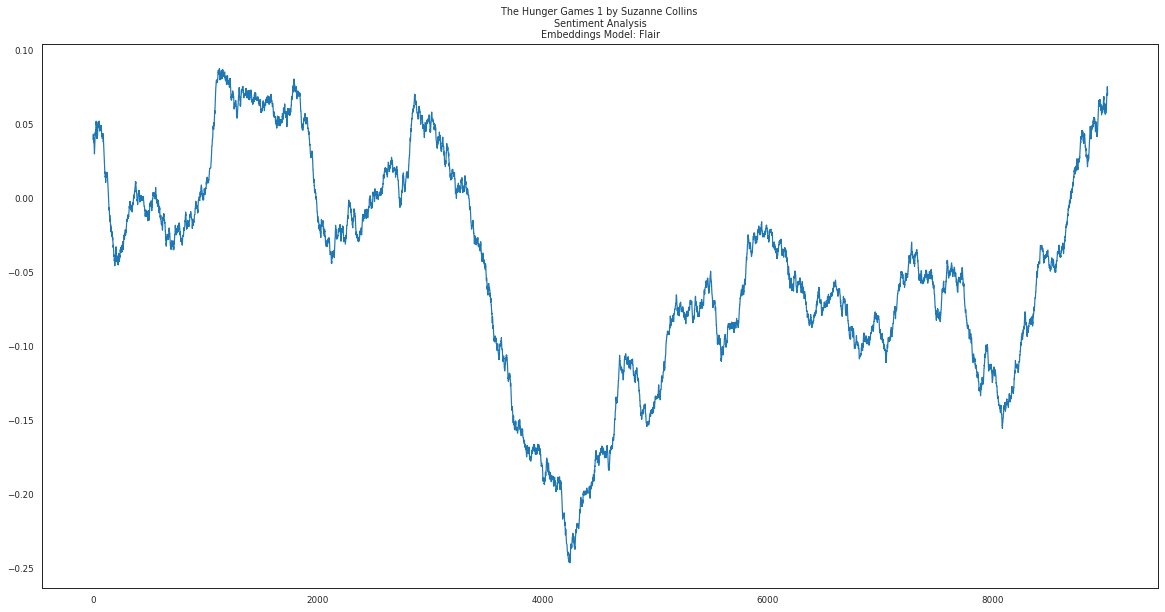

In [ ]:
# Verfiy Plausible Sentiment Values via Plot

novel_indx = 1

text_title_str = corpus_titles_ls[novel_indx]
# lexicon_name = 'jockers_rinker'
lexicon_dense = ''.join(lexicon_name.split('_'))

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {lexicon_name}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

# Save sentiment values to subdir_sentiments
write_dict_dfs(corpus_texts_dt, out_file=FNAME_SENTIMENT_RAW, out_dir=SUBDIR_SENTIMENT_RAW)
print(f'Saving Corpus_Genre: {Corpus_Genre}')
print(f'        Corpus_Type: {Corpus_Type}')
print('\n')

# Verify Dictionary was saved correctly by reading back the *.json datafile
test_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
print(f'These Text Titles:')
test_dt.keys()
print('\n')

corpus_texts_dt[corpus_titles_ls[0]].head()
print('\n')

test_dt[corpus_titles_ls[0]].info()


Saving file to: ./sentiment_raw/novels_sentiment_new_raw/sentiment_raw_novels_new_lex2ml.json
Saving Corpus_Genre: novels
        Corpus_Type: new


These Text Titles:


dict_keys(['cmieville_thecityandthecity', 'scollins_thehungergames1'])

,afinn,flair,pattern,pysentimentr_huliu,pysentimentr_jockersrinker,pysentimentr_lmcd,pysentimentr_nrc,pysentimentr_senticnet,pysentimentr_sentiword,stanza,text_clean,text_raw,textblob,vader
0,0.0,0.8531,0.000000,0.0,0.00,0.0,0.0,0.000,0.0000,10.000000,annotation,Annotation,0.000000,0.0000
1,0.0,-0.6146,0.000000,0.0,-0.25,0.0,0.0,-0.554,0.1250,5.253383,the city be beszel a rundown metropolis on the eastern edge of europe,"The city is Beszel, a rundown metropolis on the eastern edge of Europe.",0.000000,0.0000
2,0.0,-0.7487,0.018750,0.0,-0.50,1.0,-1.0,-0.705,-1.0625,5.912419,the other city be ul qoma a modern eastern european boomtown despite be a bite of a internationa...,"The other city is Ul Qoma, a modern Eastern European boomtown, despite being a bit of an interna...",0.075000,0.0000
3,1.0,0.9984,1.000000,1.0,0.10,0.0,1.0,2.543,0.6250,8.338057,what the two city share and what they do not be the deliciously evocative conundrum at the heart...,"What the two cities share, and what they don't, is the deliciously evocative conundrum at the he...",1.000000,1.3733
4,8.0,0.9982,0.158796,2.0,2.25,1.0,1.0,4.240,1.1375,13.026639,mieville be good know a a modern fantasist and urbanist but from book to book he be try on diffe...,"Mieville is well known as a modern fantasist (and urbanist), but from book to book he's tried on...",1.952778,0.9371




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10125 entries, 0 to 10124
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   afinn                       10125 non-null  float64
 1   flair                       10125 non-null  float64
 2   pattern                     10125 non-null  float64
 3   pysentimentr_huliu          10125 non-null  float64
 4   pysentimentr_jockersrinker  10125 non-null  float64
 5   pysentimentr_lmcd           10125 non-null  float64
 6   pysentimentr_nrc            10125 non-null  float64
 7   pysentimentr_senticnet      10125 non-null  float64
 8   pysentimentr_sentiword      10125 non-null  float64
 9   stanza                      10125 non-null  float64
 10  text_clean                  10125 non-null  object 
 11  text_raw                    10125 non-null  object 
 12  textblob                    10125 non-null  float64
 13  vader                       1

### **Stanza**

In [ ]:
!pip install stanza

     |████████████████████████████████| 432 kB 12.7 MB/s 
     |████████████████████████████████| 174 kB 70.0 MB/s 
  Created wheel for emoji: filename=emoji-1.6.3-py3-none-any.whl size=170298 sha256=be760c2df54cae51603382106dfb723313469f6db2bb69b736f49c04a2a88d0d
  Stored in directory: /root/.cache/pip/wheels/03/8b/d7/ad579fbef83c287215c0caab60fb0ae0f30c4d7ce5f580eade
Successfully built emoji


In [ ]:
%time

import stanza

stanza.download('en')

lexicon_name = 'Stanza'
lexicon_dense = ''.join(lexicon_name.split('_'))
lexicon_df = pd.DataFrame()

model_name = 'stanza'
model_type = 'Linguistic'

nlp = stanza.Pipeline('en', processors='tokenize,sentiment')

# Test stanza directly
doc = nlp('Ram is a bad boy')
for i, sentence in enumerate(doc.sentences):
    print(i, sentence.sentiment)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 22.6 µs


2022-03-04 06:59:59,931 : INFO : Downloading default packages for language: en (English)...


2022-03-04 07:00:19,261 : INFO : Finished downloading models and saved to /root/stanza_resources.
2022-03-04 07:00:19,269 : INFO : Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2022-03-04 07:00:19,271 : INFO : Use device: gpu
2022-03-04 07:00:19,273 : INFO : Loading: tokenize
2022-03-04 07:00:20,099 : INFO : Loading: sentiment
2022-03-04 07:00:20,774 : INFO : Done loading processors!


0 0


In [ ]:
# Test Words
print(f'Testing {lexicon_name} lexicon for WORDS Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(test_words_ls):

  # print(f'Looking up VADER sentiment for {aword_str}')
  word_sentiment_fl = stanza_discrete2continous_sentiment(aword_str.lower())
  print(f'[{word_sentiment_fl: ^8.3f}]: {aword_str}\n')


# Test Sentences
print(f'\nTesting {lexicon_name} lexicon for SENTENCES Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(test_sentences_ls):

  sent_sentiment_fl = stanza_discrete2continous_sentiment(asent_str)
  print(f'[{sent_sentiment_fl: ^8.3f}]: {asent_str}\n')


Testing Stanza lexicon for WORDS Sentiment
--------------------------------------------------
[ 20.000 ]: Love

[ 0.000  ]: Hate

[ 0.000  ]: bizarre

[ 10.000 ]: strange

[ 10.000 ]: furious

[ 20.000 ]: elated

[ 20.000 ]: curious

[ 10.000 ]: beserk

[ 10.000 ]: gambaro


Testing Stanza lexicon for SENTENCES Sentiment
--------------------------------------------------
[ 1.057  ]: I hate bad evil worthless Mondays.

[ 3.700  ]: I love Paris in the springtime

[ 2.503  ]: It was Wednesday.

[ 3.047  ]: You are a disgusting pig - I hate you.

[ 5.506  ]: What a delightfully funny and beautiful good man.

[ 2.503  ]: That was it



In [ ]:
%%time

# NOTE:  4m10s @19:38 on 20220228 Colab Pro (2 Novels)

# Compute Sentiments based upon SentimentR Lexicons

for i, atext in enumerate(corpus_texts_dt.keys()):
  models_ls = corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: stanza_discrete2continous_sentiment(x.lower()))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

Processing #0: cmieville_thecityandthecity


In [ ]:
# Verfiy Plausible Sentiment Values via Plot

novel_indx = 1

text_title_str = corpus_titles_ls[novel_indx]
# lexicon_name = 'jockers_rinker'
lexicon_dense = ''.join(lexicon_name.split('_'))

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {lexicon_name}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

# Save sentiment values to subdir_sentiments
write_dict_dfs(corpus_texts_dt, out_file=FNAME_SENTIMENT_RAW, out_dir=SUBDIR_SENTIMENT_RAW)
print(f'Saving Corpus_Genre: {Corpus_Genre}')
print(f'        Corpus_Type: {Corpus_Type}')
print('\n')

# Verify Dictionary was saved correctly by reading back the *.json datafile
test_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
print(f'These Text Titles:')
test_dt.keys()
print('\n')

corpus_texts_dt[corpus_titles_ls[0]].head()
print('\n')

test_dt[corpus_titles_ls[0]].info()


## **DNN Models**

* https://github.com/thoailinh/Sentiment-Analysis-using-BERT (Viet Comparison)

* https://github.com/Feuoy/sentiment-analysis (Chinese Comparison)

* https://www.kaggle.com/aditya6040/7-models-on-imdb-dataset-best-score-88-2/notebook#CNN-Model
* https://github.com/bentrevett/pytorch-sentiment-analysis

* https://github.com/nileshsah/deep-text-classifier/blob/master/inshorts_notebook.ipynb
* https://github.com/saurabhrathor/InceptionModel_SentimentAnalysis (fasttext emb CNN+LSTM) BB_twtr SemEval2017
* https://github.com/kaliahinartem/twitter_sentiment_analysis
* https://github.com/leelaylay/TweetSemEval


### **Common Setup**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

from keras.wrappers.scikit_learn import KerasClassifier

from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.layers import LSTM,Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from keras.callbacks import EarlyStopping

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
training_df.info()

In [ ]:
# Split labeled dataset into training, validation and test sets
# e.g. for IMDB 50k reviews: Out of 50k dataset, 36k for training, 4k for Validationa and 10k for testing

X_train, X_test, y_train, y_test = train_test_split(training_df['text_raw'], training_df['polarity'],test_size=0.2, random_state=0)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,test_size=0.1, random_state=0)

[x.shape for x in [X_train,X_valid,X_test]]


In [ ]:
X_train.shape
print('\n')
type(X_train)

In [ ]:
type(X_train)

In [ ]:
X_train[:2]

In [ ]:
%%time

# Tokenize text

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(training_df.text_raw)

X_train1 = tokenizer.texts_to_sequences(X_train)
X_valid1 = tokenizer.texts_to_sequences(X_valid)
X_test1 = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(X_train[2])
print(X_train1[2])

In [ ]:
type(X_train1)
print('\n')
X_train1

In [ ]:
corpus_sents_df.head()

In [ ]:
corpus_sents_df['sent_clean'] = corpus_sents_df['sent_clean'].astype('string')
X_corpus_ser = corpus_sents_df['sent_clean']
type(X_corpus_ser)
X_corpus_ser[:2]

In [ ]:
X_corpus1 = tokenizer.texts_to_sequences(X_corpus_ser)
type(X_corpus1)
X_corpus_ser[4]
X_corpus1[4]

In [ ]:
"""
X_corpus = np.asarray(tokenizer.texts_to_sequences(X_corpus_ser)) # , dtype=int)
X_corpus.shape
type(X_corpus)
X_corpus
""";

In [ ]:
"""
X_corpus = np.array(tokenizer.texts_to_sequences(corpus_sents_df['sent_clean'])) # , dtype=int)
X_corpus.shape
type(X_corpus)
X_corpus
""";

In [ ]:
"""
tokens_ls_ls = tokenizer.texts_to_sequences(corpus_sents_df['sent_clean'])
X_corpus_ar = np.array([np.array(lsi) for lsi in tokens_ls_ls])
X_corpus_ar
""";

In [ ]:
"""
X_corpus = np.asarray(tokenizer.texts_to_sequences(corpus_sents_df['sent_clean'])) # , dtype=int)
# X_corpus = X_corpus.astype('int32')
# npa = np.asarray(someListOfLists, dtype=np.float32)
X_corpus[:3]
print('\n')
type(X_corpus)
""";

In [ ]:
print(X_train[2])

In [ ]:
seq_lens = [len(s) for s in X_train1]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

In [ ]:
seq_lens = [len(s) for s in X_corpus1]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

In [ ]:
# Set max sequence and pad where necessary

maxlen = 150

X_train1 = pad_sequences(X_train1, padding='post', maxlen=maxlen)
X_valid1 = pad_sequences(X_valid1, padding='post', maxlen=maxlen)
X_test1 = pad_sequences(X_test1, padding='post', maxlen=maxlen)

print(X_train1[2, :])

In [ ]:
X_corpus1 = pad_sequences(X_corpus1, padding='post', maxlen=maxlen)

In [ ]:
vocab_size

### **Fully Connected Networks (FCN)**

In [ ]:
# Build the Network

embedding_dim = 50
callback = EarlyStopping(monitor='val_loss', patience=2)

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

In [ ]:
%%time

# Train the Network

history = model.fit(X_train1, y_train,epochs=10,verbose=True,validation_data=(X_valid1, y_valid),batch_size=1000,callbacks=[callback])

In [ ]:
y_test1_pred = model.predict(X_test1)
y_test1_pred

In [ ]:
y_test1_pred.size

In [ ]:
y_test1_pred_bin = np.where(y_test1_pred > 0.5, 1, 0)
y_test1_pred_bin = y_test1_pred_bin.squeeze()

In [ ]:
type(y_test1_pred_bin[0])

In [ ]:
y_test

In [ ]:
y_test_fl = y_test.apply(lambda x: float(x))
y_test_fl

In [ ]:
y_test_ar = np.array(y_test_fl, dtype=np.float32)
type(y_test_ar)
print('\n')
y_test_ar.shape
print('\n')
y_test_ar

In [ ]:
type(y_test1_pred)
print('\n')
y_test1_pred = y_test1_pred.squeeze()
y_test1_pred.shape
print('\n')
y_test1_pred

In [ ]:
accuracy_score(y_test, y_test1_pred_bin)

In [ ]:
plot_history(history)

In [ ]:
plt.figure(figsize=(4,4))
# sns.heatmap(confusion_matrix(y_test, model.predict(X_test1)),annot=True,cmap='coolwarm',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
sns.heatmap(confusion_matrix(y_test, y_test1_pred_bin),annot=True,cmap='coolwarm',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
plt.xlabel("Predicted",fontsize=16)
plt.ylabel("Actual",fontsize=16)
plt.show();

In [ ]:
y_corpus1_pred = model.predict(X_corpus1)
type(y_corpus1_pred)
print('\n')
print(y_corpus1_pred)

In [ ]:
fcn_ar = y_corpus1_pred.squeeze()
fcn_ar.shape

In [ ]:
corpus_sents_df['fcn'] = pd.Series(fcn_ar)

In [ ]:
# corpus_sents_df['fcn'].apply(lambda x: 6*(x-0.3)).rolling(900, center=True).mean().plot(label='Fully Connected Neural Net')
corpus_sents_df['fcn'].apply(lambda x: 8*(x-0.55)).rolling(900, center=True).mean().plot(label='Fully Connected Neural Net')
corpus_sents_df['sentimentr_stdscaler'].rolling(900, center=True).mean().plot(label='SentimentR')
corpus_sents_df['vader_stdscaler'].rolling(900, center=True).mean().plot(label='VADER')
plt.legend(loc='best');
plt.title(f'{CORPUS_FULL}\nFully Connected Neural Net (Default w/IMDB) SMA=10%');

### **RNN**

### **LSTM**

**Ref: https://www.kaggle.com/derrelldsouza/imdb-sentiment-analysis-eda-ml-lstm-bert#4.-Predictive-Modelling-using-Machine-Learning**

In [ ]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig , ax = plt.subplots(1,2,figsize = (10,5))
  
  ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()
  ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  fig.tight_layout()
  plt.show()



In [ ]:
#set up the tokenizer
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

#print(word_index)
V = len(word_index)
print("Vocabulary of the dataset is : ",V)

In [ ]:
##create sequences of reviews
seq_train = tokenizer.texts_to_sequences(X_train)
seq_test =  tokenizer.texts_to_sequences(X_test)

In [ ]:
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

In [ ]:
# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

In [ ]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

In [ ]:
#create padded sequences
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [ ]:
#Splitting training set for validation purposes
Xtrain,Xval,ytrain,yval=train_test_split(pad_train,y_train, test_size=0.2,random_state=10)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [ ]:
def lstm_model(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
#     #early_stop = EarlyStopping(monitor='val_accuracy', 
#                                mode='min', 
#                                patience = 2 )
#     #checkpoints= ModelCheckpoint(filepath='./',
#                             monitor="val_accuracy",
#                             verbose=0,
#                             save_best_only=True
#                            )
  #  callbacks = [checkpoints,early_stop]
    r = model.fit(Xtrain,ytrain, 
                  validation_data = (Xval,yval), 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [ ]:
%%time

# NOTE: 3m51s

D = 64 #embedding dims
epochs = 5
r,model,n_epochs = lstm_model(Xtrain,Xval,ytrain,yval,V,D,max_seq_len,epochs)

In [ ]:
#Plot accuracy and loss

plotLearningCurve(r,n_epochs)

In [ ]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(pad_test,y_test)
print(dict(zip(model.metrics_names, result)))

In [ ]:
#Generate predictions for the test dataset
ypred = model.predict(pad_test)
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
X_corpus_ser = corpus_sents_df['sent_clean']
type(X_corpus_ser)
X_corpus_ser[:5]

In [ ]:
type(X_corpus)

In [ ]:
##create sequences of reviews
seq_corpus = tokenizer.texts_to_sequences(X_corpus_ser)
# seq_test =  tokenizer.texts_to_sequences(X_test)

In [ ]:
type(seq_corpus)

In [ ]:
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_corpus]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

In [ ]:
# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

In [ ]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

In [ ]:
max_seq_len

In [ ]:
#create padded sequences
pad_corpus=pad_sequences(seq_corpus,truncating = 'post', padding = 'pre',maxlen=584) # max_seq_len)
# pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [ ]:
#Generate predictions for the corpus dataset
y_corpus_pred = model.predict(pad_corpus)
y_corpus_pred.shape
y_corpus_pred

In [ ]:
lstm_ar = y_corpus_pred.squeeze()
lstm_ar.shape

In [ ]:
corpus_sents_df['lstm'] = pd.Series(lstm_ar)

In [ ]:
corpus_sents_df['fcn'].apply(lambda x: 8*(x-0.55)).rolling(900, center=True).mean().plot(label='Fully Connected Neural Net')
corpus_sents_df['lstm'].apply(lambda x: 5*(x-0.47)).rolling(900, center=True).mean().plot(label='LSTM Neural Net')
corpus_sents_df['sentimentr_stdscaler'].rolling(900, center=True).mean().plot(label='SentimentR')
corpus_sents_df['vader_stdscaler'].rolling(900, center=True).mean().plot(label='VADER')
plt.legend(loc='best');
plt.title(f'{CORPUS_FULL}\nLSTM Neural Net (Default w/IMDB) SMA=10%');

In [ ]:
corpus_root_filename

In [ ]:
corpus_sents_df.to_csv(f'sum_4andDNN_{corpus_root_filename}.csv')

**Ref: https://www.kaggle.com/aditya6040/7-models-on-imdb-dataset-best-score-88-2/notebook#CNN-Model**

In [ ]:
embedding_vecor_length = 32
callback = EarlyStopping(monitor='val_loss', patience=2)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

In [ ]:
model.fit(X_train1, y_train, epochs=10, batch_size=256,verbose = 1,validation_data=(X_valid1,y_valid),callbacks=[callback])

In [ ]:
accuracy_score(y_test, model.predict(X_test1))

In [ ]:
history.history

In [ ]:
plot_history(history)

In [ ]:
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test, model.predict(X_test1)),annot=True,cmap='coolwarm',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
plt.xlabel("Predicted",fontsize=16)
plt.ylabel("Actual",fontsize=16)
plt.show()

### **CNN**

* https://github.com/bentrevett/pytorch-sentiment-analysis (CNN w/GLoVE and IMDB)

* https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

In [ ]:
embedding_vecor_length = 32
callback = EarlyStopping(monitor='val_loss', patience=2)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

In [ ]:
%%time

# NOTE: 

model.fit(X_train1, y_train, epochs=10, batch_size=256,verbose = 1,validation_data=(X_valid1,y_valid),callbacks=[callback])

In [ ]:
accuracy_score(y_test, model.predict_classes(X_test1))

In [ ]:
plot_history(history)

### **BERT**

In [ ]:
# https://www.kaggle.com/derrelldsouza/imdb-sentiment-analysis-eda-ml-lstm-bert#5.-Predictive-Modelling-using-Deep-Learning

#Perform tokenization
# automatically download the vocab used during pretraining or fine-tuning a given model,use from_pretrained() method
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
#pass our texts to the tokenizer

Xtrain_enc = tokenizer(Xtrain.tolist(), max_length=max_seq_len, 
                         truncation=True, padding='max_length', 
                         add_special_tokens=True, return_tensors='np') #return numpy object
Xval_enc = tokenizer(Xval.tolist(), max_length=max_seq_len, 
                         truncation=True, padding='max_length', 
                         add_special_tokens=True, return_tensors='np') #return numpy object
Xtest_enc = tokenizer(Xtest.tolist(), max_length=max_seq_len, 
                         truncation=True, padding='max_length', 
                         add_special_tokens=True, return_tensors='np') #return numpy object

In [ ]:
#preparing our datasets

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtrain_enc),
    ytrain
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xval_enc),
    yval
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtest_enc),
    ytest
))

In [ ]:
def bert_model(train_dataset,val_dataset,transformer,max_len,epochs):
    print("----Building the model----")
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,),dtype=tf.int32,name = 'attention_mask') #attention mask
    sequence_output = transformer(input_ids,attention_mask)[0]
    cls_token = sequence_output[:, 0, :]
    x = Dense(512, activation='relu')(cls_token)
    x = Dropout(0.1)(x)
    y = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[input_ids,attention_mask], outputs=y)
    model.summary()
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    r = model.fit(train_dataset.batch(32),batch_size = 32,
                  validation_data = val_dataset.batch(32),epochs = epochs)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(train_dataset.batch(32)))
    print("Validation score:", model.evaluate(val_dataset.batch(32)))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [ ]:
transformer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

In [ ]:
epochs = 2
max_len = max_seq_len
r,model,n_epochs = bert_model(train_dataset,val_dataset,transformer,max_len,epochs)

In [ ]:
#Plot accuracy and loss
plotLearningCurve(r,n_epochs)

In [ ]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(test_dataset.batch(32))
print(dict(zip(model.metrics_names, result)))

In [ ]:
#Generate predictions for the test dataset
ypred = model.predict(test_dataset.batch(32))
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## AutoML

### AutoKeras

* https://autokeras.com/tutorial/text_classification/

In [ ]:
# RESTART RUNTIME

!pip install autokeras

In [ ]:
import os

import numpy as np
import tensorflow as tf
from sklearn.datasets import load_files

import autokeras as ak

In [ ]:
dataset = tf.keras.utils.get_file(
    fname="aclImdb.tar.gz",
    origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    extract=True,
)

# set path to dataset
IMDB_DATADIR = os.path.join(os.path.dirname(dataset), "aclImdb")

classes = ["pos", "neg"]
train_data = load_files(
    os.path.join(IMDB_DATADIR, "train"), shuffle=True, categories=classes
)
test_data = load_files(
    os.path.join(IMDB_DATADIR, "test"), shuffle=False, categories=classes
)

x_train = np.array(train_data.data)
y_train = np.array(train_data.target)
x_test = np.array(test_data.data)
y_test = np.array(test_data.target)

print(x_train.shape)  # (25000,)
print(y_train.shape)  # (25000, 1)
print(x_train[0][:50])  # this film was just brilliant casting

In [ ]:
# Initialize the text classifier.
clf = ak.TextClassifier(
    overwrite=True, max_trials=1
)  # It only tries 1 model as a quick demo.

# Feed the text classifier with training data.
clf.fit(x_train, y_train, epochs=2)

# Predict with the best model.
predicted_y = clf.predict(x_test)

# Evaluate the best model with testing data.
print(clf.evaluate(x_test, y_test))

In [ ]:
clf.fit(
    x_train,
    y_train,
    # Split the training data and use the last 15% as validation data.
    validation_split=0.15,
)

In [ ]:
"""
split = 5000
x_val = x_train[split:]
y_val = y_train[split:]
x_train = x_train[:split]
y_train = y_train[:split]

clf.fit(
    x_train,
    y_train,
    epochs=2,
    # Use your own validation set.
    validation_data=(x_val, y_val),
)
""";

In [ ]:
input_node = ak.TextInput()
output_node = ak.TextBlock(block_type="ngram")(input_node)
output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=1
)
clf.fit(x_train, y_train, epochs=2)

### Pytorch-Optimize

* https://github.com/jettify/pytorch-optimizer (20210705 2k)

### Keras-Tuner

* https://github.com/keras-team/keras-tuner


# **[STEP 5] Transformer Models**

In [31]:
from transformers import pipeline

In [32]:
# Define all Corpus Texts & Ensemble Models as global CONSTANTS

model_family = 'transformer'

# Verify in SentimentArcs Root Directory
os.chdir(Path_to_SentimentArcs)
%run -i './utils/get_sentiments.py'

#@markdown If Model Values already exist, Recompute anyway and Overwrite?

Force_Recompute = False #@param {type:"boolean"}

# Get list Names for This Section of Python Lexicon Models

# models_lexicon_ls = ensemble_models_dt['lexicon']
models_pylex_ls = [x for x in global_vars.model_ensemble_dt[model_family]]
print(f'Lexicon Models in this Section:\n')
print(models_pylex_ls)

Lexicon Models in this Section:

['imdb2way', 'hinglish', 'nlptown', 'yelp', 'huggingface', 'roberta15lg', 'robertaxml8lang', 't5imdb50k']


In [35]:
# from utils import sa_config (e.g. define TEST_WORDS_LS)

sa_config.set_globals()

global_vars.TEST_WORDS_LS

['Love',
 'Hate',
 'bizarre',
 'strange',
 'furious',
 'elated',
 'curious',
 'beserk',
 'gambaro']

In [29]:
global_vars.models_titles_dt

{'AFINN': ['afinn', 'lexicon', 7520],
 'AutoGluon_Text': ['autogluon', 'tradml', 'autogluon_text'],
 'BERT_2IMDB': ['imdb2way', 'transformer', 'bert'],
 'BERT_Dual_Coding': ['hinglish', 'transformer', 'bert'],
 'BERT_Multilingual': ['nlptown', 'transformer', 'bert'],
 'BERT_Yelp': ['yelp', 'transformer', 'bert'],
 'CNN_DNN': ['cnn', 'dnn', 1315937],
 'Distilled_BERT': ['huggingface', 'transformer', 'bert'],
 'FLAML_AutoML': ['flaml', 'tradml', 'flaml'],
 'Fully_Connected_Network': ['fcn', 'dnn', 6287671],
 'HyperOpt_CNN_Flair_AutoML': ['flair', 'dnn', 0],
 'LSTM_DNN': ['lstm', 'dnn', 7109089],
 'Logistic_Regression': ['logreg', 'tradml', 'scikit'],
 'Logistic_Regression_CV': ['logreg_cv', 'tradml', 'scikit'],
 'Multilingual_CNN_Stanza_AutoML': ['stanza', 'dnn', 0],
 'Multinomial_Naive_Bayes': ['multinb', 'tradml', 'scikit'],
 'Pattern': ['pattern', 'heuristic', 2918],
 'PySentimentR_Huliu': ['pysentimentr_huliu', 'lexicon', 5469],
 'PySentimentR_JockersRinker': ['pysentimentr_jockersri

In [30]:
global_vars.model_ensemble_dt.keys()

dict_keys(['lexicon', 'heuristic', 'ml', 'dnn', 'transformer'])

## **RoBERTa Large 15 Datasets (5 cats)**

* https://huggingface.co/siebert/sentiment-roberta-large-english
* https://huggingface.co/roberta-base 

In [ ]:
%%time

# NOTE: 00m11s @12:39 on 20220301 Colab Pro 

sa_model = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")
print(sa_model("I love this!"))

Downloading:   0%|          | 0.00/687 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9988656044006348}]
CPU times: user 43.9 s, sys: 8.33 s, total: 52.2 s
Wall time: 1min 4s


In [ ]:
# Define Model and Test

model_title = 'RoBERTa Large 15DB'
model_name = 'roberta15lg'
model_type = 'Transformer'

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  word_sentiment_fl = sa_model(aword_str)
  print(f'Word: {aword_str}\n    {word_sentiment_fl}\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  sent_sentiment_fl = sa_model(asent_str)
  print(f'Sentence: {asent_str}\n    {sent_sentiment_fl}\n')

Testing WORD Sentiment
--------------------------------------------------
Word: Love
    [{'label': 'POSITIVE', 'score': 0.9969683289527893}]

Word: Hate
    [{'label': 'NEGATIVE', 'score': 0.9959344863891602}]

Word: bizarre
    [{'label': 'POSITIVE', 'score': 0.9868559241294861}]

Word: strange
    [{'label': 'NEGATIVE', 'score': 0.9920816421508789}]

Word: furious
    [{'label': 'NEGATIVE', 'score': 0.9632396101951599}]

Word: elated
    [{'label': 'POSITIVE', 'score': 0.9961071610450745}]

Word: curious
    [{'label': 'POSITIVE', 'score': 0.9934197068214417}]

Word: beserk
    [{'label': 'NEGATIVE', 'score': 0.9948800802230835}]

Word: gambaro
    [{'label': 'POSITIVE', 'score': 0.9791625738143921}]


Testing SENTENCE Sentiment
--------------------------------------------------
Sentence: I hate bad evil worthless Mondays.
    [{'label': 'NEGATIVE', 'score': 0.9989356398582458}]

Sentence: I love Paris in the springtime
    [{'label': 'POSITIVE', 'score': 0.9988493919372559}]

Sente

In [ ]:
# Verify saving results to correct model name

print(f'Saving results to Model: {model_name}')

Saving results to Model: roberta15lg


In [ ]:
%%time

# NOTE:   ~40m00s @12:39 on 20220301 Colab Pro P100 (1 Novels)
#       ~1h31m00s @12:39 on 20220301 Colab Pro P100 (2 Novels)

#         ~00m00s @01:55 on 20220411 Colab Pro P100 (2 Novels/Corpus1)
#        3h08m00s @03:12 on 20220412 Colab Pro P100 (3 Novels/Corpus2)

# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    # global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].apply(lambda x: labelscore2fl(classifier(x), sa_model=classifier))
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].apply(lambda x: labelscore2fl(sa_model(x), sa_model=model_name))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

Processing #0: tmorrison_songofsolomon
  [roberta15lg] Sentiment Recomputed and Value Updated
Processing #1: cliu_threebodyproblem
  [roberta15lg] Sentiment Recomputed and Value Updated
Processing #2: sking_doctorsleep
  [roberta15lg] Sentiment Recomputed and Value Updated
CPU times: user 3h 7min 56s, sys: 28.9 s, total: 3h 8min 25s
Wall time: 3h 8min 19s


In [ ]:
%%time
"""
# NOTE:   ~40m00s @12:39 on 20220301 Colab Pro P100 (1 Novels)
#       ~1h31m00s @12:39 on 20220301 Colab Pro P100 (2 Novels)

# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  print(f"Processing #{i}: {atext}")

  corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].progress_apply(lambda x: labelscore2fl(sa_model(x)))
""";

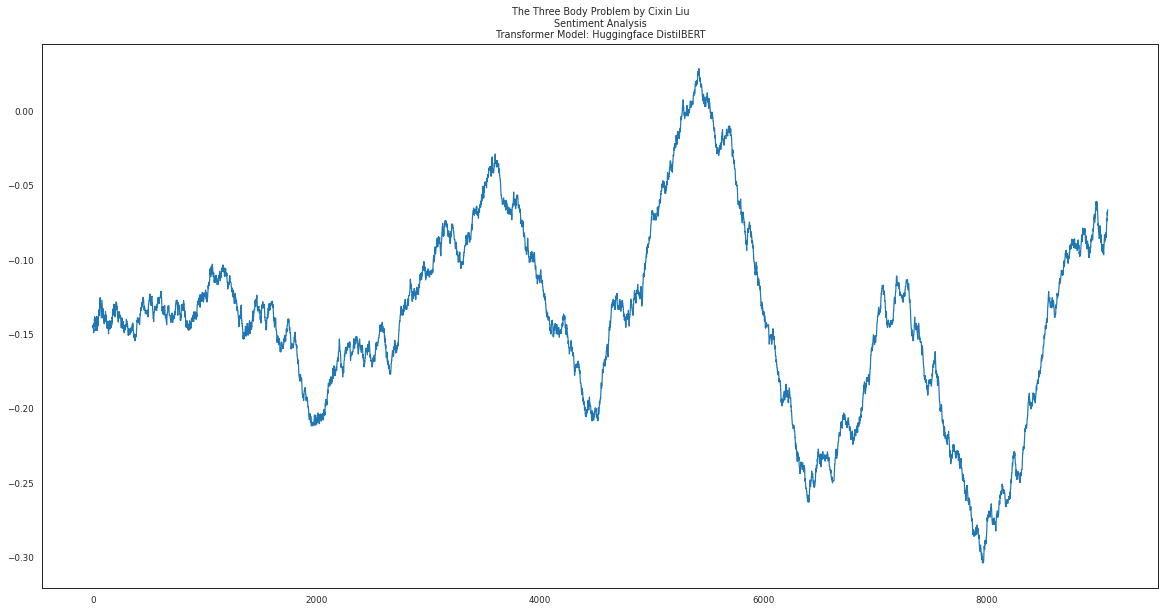

In [65]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 1
corpus_text_str = corpus_titles_ls[novel_indx]

win_10per = int(0.10*global_vars.corpus_texts_dt[corpus_text_str].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory
os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW

In [ ]:
# Verify Saving Corpus

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

print(f'\nThese Text Titles:\n')
corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW

In [ ]:
# Save sentiment values to subdir_sentiments

os.chdir(Path_to_SentimentArcs)

save_filename = f'all_{Corpus_Genre}_{Corpus_Type}_roberta.json'

write_dict_dfs(global_vars.corpus_texts_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}/')

Saving file to: ./sentiment_raw/sentiment_raw_novels_new_corpus2//all_novels_new_roberta.json


In [ ]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

total 8285
-rw------- 1 root root       0 Apr 10 17:52 test.txt
-rw------- 1 root root 8483026 Apr 12 10:20 all_novels_new_roberta.json


In [ ]:
# [SKIP]

In [ ]:
%whos

Interactive namespace is empty.


In [ ]:
# Save sentiment values to subdir_sentiments
save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_dnn2transformer.json'
write_dict_dfs(corpus_texts_dt, out_file=save_filename, out_dir=SUBDIR_SENTIMENT_RAW)
print(f'Saving Text_Type: {Text_Type}')
print(f'     Corpus_Type: {Corpus_Type}')
print('\n')

# Verify Dictionary was saved correctly by reading back the *.json datafile
test_dt = read_dict_dfs(in_file=save_filename, in_dir=SUBDIR_SENTIMENT_RAW)
print(f'These Text Titles:')
test_dt.keys()
print('\n')

corpus_texts_dt[corpus_titles_ls[0]].head()
print('\n')

test_dt[novels_titles_ls[0]].info()


## **Huggingface Distill BERT SST**

In [99]:
# BUG: Cannot reuse variable name 'sa_model', causes replicated results of first model declared (e.g. roberta15lg)
# sa_model = pipeline("sentiment-analysis")

# Huggingface default sentiment classifier model:
#   distilbert-base-uncased-finetuned-sst-2-english
sa_model = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [100]:
# Define Model and Test

model_title = 'Huggingface DistilBERT'
model_name = 'huggingface'
model_type = 'Transformer'

# Test Emoji
classifier("We are very happy to show you the 🤗 Transformers library.")
print('\n\n')

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  word_sentiment_fl = sa_model_huggingface(aword_str)
  print(f'Word: {aword_str}\n    {word_sentiment_fl}\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  sent_sentiment_fl = sa_model_huggingface(asent_str)
  print(f'Sentence: {asent_str}\n    {sent_sentiment_fl}\n')

[{'label': 'POSITIVE', 'score': 0.9997795224189758}]




Testing WORD Sentiment
--------------------------------------------------
Word: Love
    [{'label': 'POSITIVE', 'score': 0.9998735189437866}]

Word: Hate
    [{'label': 'NEGATIVE', 'score': 0.9996899366378784}]

Word: bizarre
    [{'label': 'NEGATIVE', 'score': 0.9943822622299194}]

Word: strange
    [{'label': 'NEGATIVE', 'score': 0.9787243008613586}]

Word: furious
    [{'label': 'NEGATIVE', 'score': 0.999466598033905}]

Word: elated
    [{'label': 'POSITIVE', 'score': 0.9998383522033691}]

Word: curious
    [{'label': 'POSITIVE', 'score': 0.9969179630279541}]

Word: beserk
    [{'label': 'POSITIVE', 'score': 0.5606897473335266}]

Word: gambaro
    [{'label': 'POSITIVE', 'score': 0.9166504144668579}]


Testing SENTENCE Sentiment
--------------------------------------------------
Sentence: I hate bad evil worthless Mondays.
    [{'label': 'NEGATIVE', 'score': 0.9908758401870728}]

Sentence: I love Paris in the springtime
    [{'label': 'POSITIVE', 'score': 0.9998341798782349}]

Sen

In [101]:
# Verify saving results to correct model name

print(f'Saving results to Model: {model_name}')

Saving results to Model: huggingface


In [ ]:
%%time

# NOTE: 

# NOTE:   10m25s @02:48 on 20220304 Colab Pro T4 (2 Novels ~1k sents each)
#         24m26s @08:58 on 20220412 Colab Pro P100 (3 Novels, 1.2M, 1.3M, 1.7M)

for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].apply(lambda x: labelscore2fl(classifier(x), sa_model=sa_model))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

Processing #0: tmorrison_songofsolomon
  [huggingface] Sentiment Recomputed and Value Updated
Processing #1: cliu_threebodyproblem
  [huggingface] Sentiment Recomputed and Value Updated
Processing #2: sking_doctorsleep
  [huggingface] Sentiment Recomputed and Value Updated
CPU times: user 22min 59s, sys: 3.46 s, total: 23min 2s
Wall time: 22min 58s


In [ ]:
global_vars.corpus_texts_dt['tmorrison_songofsolomon']['huggingface'].rolling(600, center=True, min_periods=0).mean().plot()

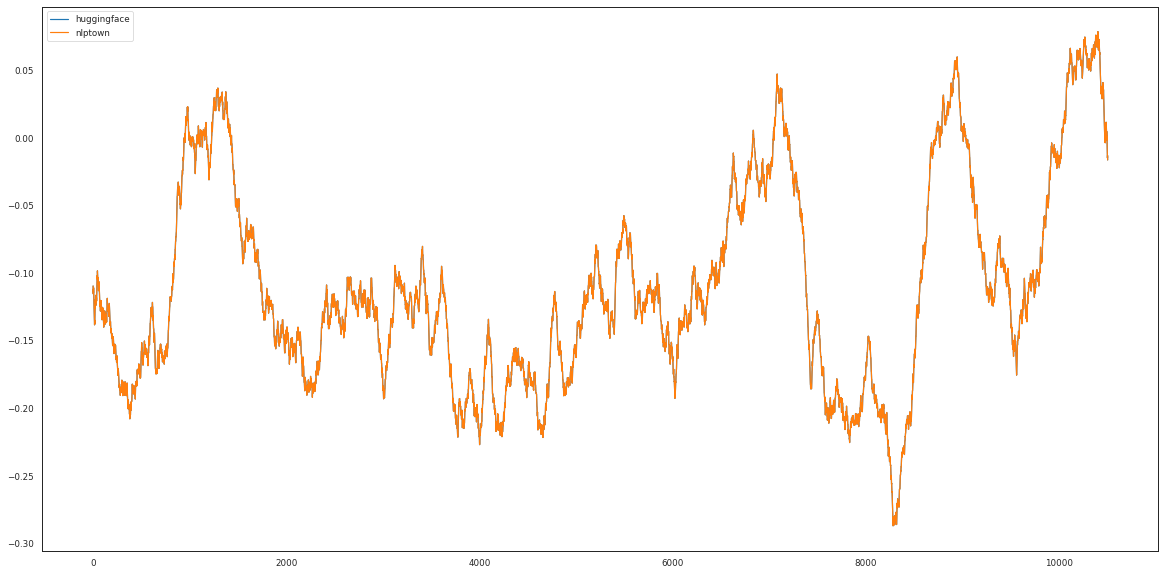

In [96]:
models_all_ls = list(global_vars.corpus_texts_dt['tmorrison_songofsolomon'].select_dtypes(include=[np.float]).columns)

global_vars.corpus_texts_dt['tmorrison_songofsolomon'][models_all_ls].rolling(600, center=True, min_periods=0).mean().plot()

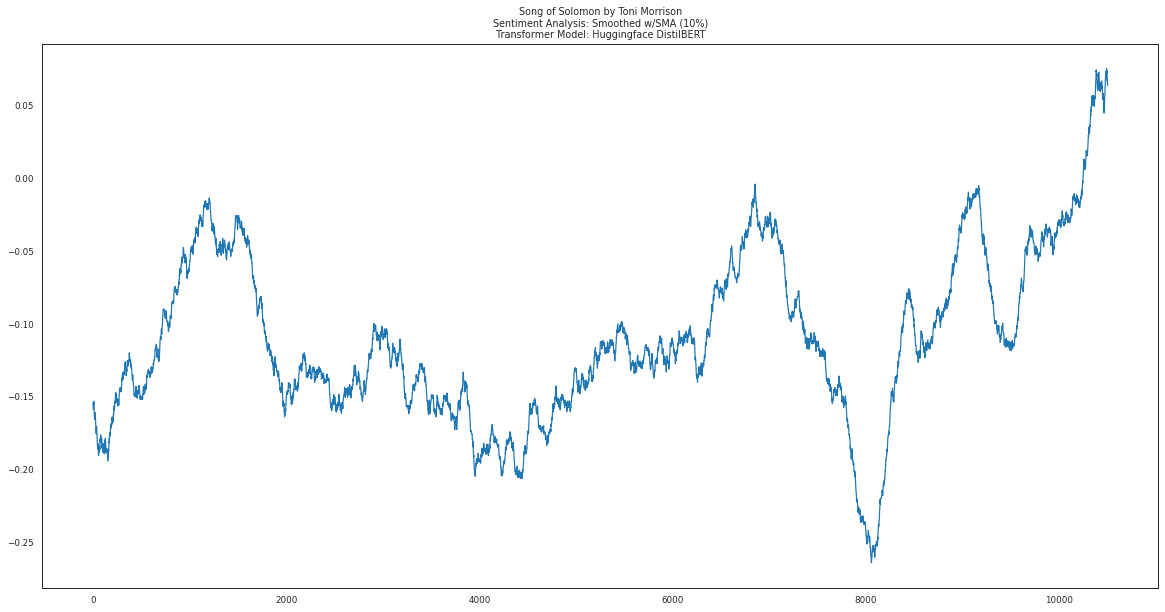

In [76]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_titles_ls[novel_indx]
# amodel_str = 'huggingface' 
win_aper = 10

win_10per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][novel_indx]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.show();

In [56]:
"""

# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 1
text_title_str = corpus_texts_ls[novel_indx]

win_10per = int(0.10*global_vars.corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{global_vars.corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

""";

KeyError: ignored

### **Save Checkpoint**

In [83]:
# Verify in SentimentArcs Root Directory
os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_huggingface.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_reference_transformer_huggingface.json'

write_dict_dfs(global_vars.corpus_texts_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}')



Currently in SentimentArcs root directory:
/gdrive/MyDrive/sentimentarcs_notebooks
Saving Text_Type: novels
     Corpus_Type: new

These Text Titles:



dict_keys(['tmorrison_songofsolomon', 'cliu_threebodyproblem', 'sking_doctorsleep'])


To This Subdirectory:



'./sentiment_raw/sentiment_raw_novels_new_corpus2/'

Saving file to: ./sentiment_raw/sentiment_raw_novels_new_corpus2/sentiment_raw_novels_new_corpus2_transformer_huggingface.json


In [84]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

total 24854
-rw------- 1 root root       0 Apr 10 17:52 test.txt
-rw------- 1 root root 8483161 Apr 12 13:55 all_novels_new_huggingface.json
-rw------- 1 root root 8483161 Apr 12 13:59 sentiment_raw_novels_new_corpus2_transformer_huggingface.json
-rw------- 1 root root 8483026 Apr 12 14:01 sentiment_raw_novels_new_corpus_2_transformer_roberta.json


In [ ]:
# [SKIP]

In [ ]:
# Verify in SentimentArcs Root Directory

os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
!pwd

In [ ]:
# Save sentiment values to subdir_sentiments
# save_filename = f'sentiment_raw_{Corpus_Type}_{Text_Type}_dnn2transformer.json'
write_dict_dfs(corpus_texts_dt, out_file=FNAME_SENTIMENT_RAW, out_dir=SUBDIR_SENTIMENT_RAW)
print(f'Saving Text_Type: {Text_Type}')
print(f'     Corpus_Type: {Corpus_Type}')
print('\n')

# Verify Dictionary was saved correctly by reading back the *.json datafile
test_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
print(f'These Text Titles:')
test_dt.keys()
print('\n')

corpus_texts_dt[corpus_titles_ls[0]].head()
print('\n')

test_dt[novels_titles_ls[0]].info()


## **NLPTown Multilingual BERT (5 cats)**

* https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment

In [85]:
# NLPTown: Multilingual trained BERT Model

# sa_nlptown 
sa_model = pipeline("sentiment-analysis",model="nlptown/bert-base-multilingual-uncased-sentiment")

# Test
# print(sa_nlptown("I love this!"))
print(sa_model("I love this!"))

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

NameError: ignored

In [86]:
# Define Model and Test

model_title = 'NLPTown MultiBERT'
model_name = 'nlptown'
model_type = 'Transformer'

# Test Emoji
classifier("We are very happy to show you the 🤗 Transformers library.")
print('\n\n')

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  word_sentiment_fl = sa_model(aword_str)
  print(f'Word: {aword_str}\n    {word_sentiment_fl}\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  sent_sentiment_fl = sa_model(asent_str)
  print(f'Sentence: {asent_str}\n    {sent_sentiment_fl}\n')

[{'label': 'POSITIVE', 'score': 0.9997795224189758}]




Testing WORD Sentiment
--------------------------------------------------
Word: Love
    [{'label': '5 stars', 'score': 0.6595041751861572}]

Word: Hate
    [{'label': '1 star', 'score': 0.693548321723938}]

Word: bizarre
    [{'label': '1 star', 'score': 0.3379124104976654}]

Word: strange
    [{'label': '1 star', 'score': 0.28947705030441284}]

Word: furious
    [{'label': '1 star', 'score': 0.6228679418563843}]

Word: elated
    [{'label': '2 stars', 'score': 0.34351810812950134}]

Word: curious
    [{'label': '3 stars', 'score': 0.387085884809494}]

Word: beserk
    [{'label': '5 stars', 'score': 0.312057226896286}]

Word: gambaro
    [{'label': '3 stars', 'score': 0.2532377541065216}]


Testing SENTENCE Sentiment
--------------------------------------------------
Sentence: I hate bad evil worthless Mondays.
    [{'label': '1 star', 'score': 0.8850790858268738}]

Sentence: I love Paris in the springtime
    [{'label': '5 stars', 'score': 0.6275702118873596}]

Sentence: It was We

In [ ]:
"""

# Define Model and Test

model_title = 'NLPTown MultiBERT'
model_name = 'nlptown'
model_type = 'Transformer'

# Test Emoji
classifier("We are very happy to show you the 🤗 Transformers library.")
print('\n\n')

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  word_sentiment_fl = sa_model(aword_str)
  print(f'Word: {aword_str}\n    {word_sentiment_fl}\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  sent_sentiment_fl = sa_model(asent_str)
  print(f'Sentence: {asent_str}\n    {sent_sentiment_fl}\n')
"""


"""
# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(test_words_ls):

  word_sentiment_fl = sa_nlptown(aword_str)
  print(f'Word: {aword_str}\n    {word_sentiment_fl}\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(test_sentences_ls):

  sent_sentiment_fl = labelscore2fl(sa_nlptown(asent_str), sa_model=sa_nlptown)
  print(f'Sentence: {asent_str}\n    {sent_sentiment_fl:.3f}\n')
""";

In [87]:
# Verify saving results to correct model name

print(f'Saving results to Model: {model_name}')

Saving results to Model: nlptown


In [88]:
%%time

# NOTE:   9m05s @16:40 on 20220301 Colab Pro P100 (1 Novel: cmieville_thecityandthecity)
#        ~8m07s @16:49 on 20220201 Colab Pro P100 (1 Novel: scollins_thehungergames1)
#        25m14s @08:58 on 20220412 Colab Pro P100 (3 Novels, 1.2M, 1.3M, 1.7M)

for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].apply(lambda x: labelscore2fl(classifier(x), sa_model=sa_model))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

Processing #0: tmorrison_songofsolomon
  [nlptown] Sentiment Recomputed and Value Updated
Processing #1: cliu_threebodyproblem
  [nlptown] Sentiment Recomputed and Value Updated
Processing #2: sking_doctorsleep
  [nlptown] Sentiment Recomputed and Value Updated
CPU times: user 24min 32s, sys: 4.19 s, total: 24min 36s
Wall time: 25min 14s


In [ ]:
"""
%%time

# NOTE:   9m05s @16:40 on 20220301 Colab Pro P100 (1 Novel: cmieville_thecityandthecity)
#         ~8m07s @16:49 on 20220201 Colab Pro P100 (1 Novel: scollins_thehungergames1)

# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].apply(lambda x: labelscore2fl(sa_nlptown(x), sa_model=sa_nlptown))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')
""";

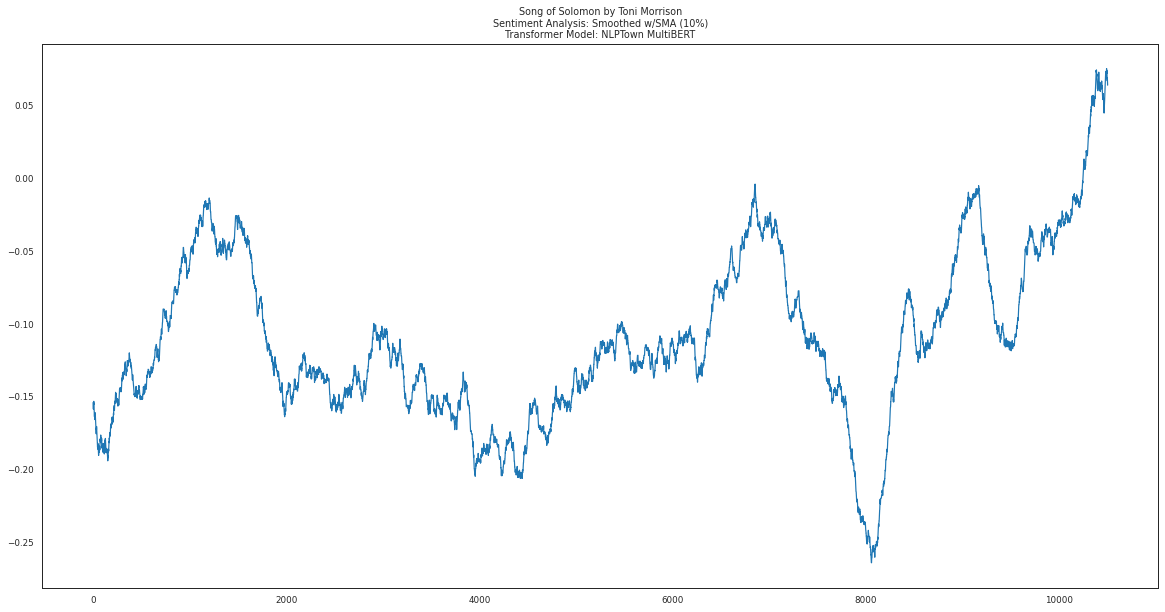

In [89]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_titles_ls[novel_indx]
# amodel_str = 'huggingface' 
win_aper = 10

win_10per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][novel_indx]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.show();

In [ ]:
"""
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 1
text_title_str = corpus_titles_ls[novel_indx]

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {model_title}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();
""";

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory
os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_huggingface.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_reference_transformer_huggingface.json'

write_dict_dfs(global_vars.corpus_texts_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}')



Currently in SentimentArcs root directory:
/gdrive/MyDrive/sentimentarcs_notebooks
Saving Text_Type: novels
     Corpus_Type: new

These Text Titles:



dict_keys(['tmorrison_songofsolomon', 'cliu_threebodyproblem', 'sking_doctorsleep'])


To This Subdirectory:



'./sentiment_raw/sentiment_raw_novels_new_corpus2/'

Saving file to: ./sentiment_raw/sentiment_raw_novels_new_corpus2/sentiment_raw_novels_new_corpus2_transformer_huggingface.json


In [ ]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

total 24854
-rw------- 1 root root       0 Apr 10 17:52 test.txt
-rw------- 1 root root 8483161 Apr 12 13:55 all_novels_new_huggingface.json
-rw------- 1 root root 8483161 Apr 12 13:59 sentiment_raw_novels_new_corpus2_transformer_huggingface.json
-rw------- 1 root root 8483026 Apr 12 14:01 sentiment_raw_novels_new_corpus_2_transformer_roberta.json


In [ ]:
# [SKIP]

In [ ]:
# Verify in SentimentArcs Root Directory

os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
!pwd

In [ ]:
# Save sentiment values to subdir_sentiments
# save_filename = f'sentiment_raw_{Corpus_Type}_{Text_Type}_dnn2transformer.json'
write_dict_dfs(corpus_texts_dt, out_file=FNAME_SENTIMENT_RAW, out_dir=SUBDIR_SENTIMENT_RAW)
print(f'Saving Text_Type: {Text_Type}')
print(f'     Corpus_Type: {Corpus_Type}')
print('\n')

# Verify Dictionary was saved correctly by reading back the *.json datafile
test_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
print(f'These Text Titles:')
test_dt.keys()
print('\n')

corpus_texts_dt[corpus_titles_ls[0]].head()
print('\n')

test_dt[novels_titles_ls[0]].info()


## **Yelp Finetuned BERT (5 cats)**

* https://huggingface.co/gilf/english-yelp-sentiment

In [ ]:
# Yelp Trained BERT Sentiment Classifier

# from transformers import AutoTokenizer, AutoModelForSequenceClassification (above)
tokenizer = AutoTokenizer.from_pretrained("gilf/english-yelp-sentiment")

# sa_yelp 
sa_model = AutoModelForSequenceClassification.from_pretrained("gilf/english-yelp-sentiment")

In [ ]:
# Test

text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_yelp(**text_enc)
print(f'Yelp SA Model:\n  INPUT: {text_str}\n  SENTIMENT: {text_sentiment}')
print(f'  TYPE: {type(text_sentiment)}')
text_smax_ls_ls = text_sentiment.logits.softmax(dim=-1).tolist()
text_smax_ls = text_smax_ls_ls[0]
print(type(text_smax_ls[0]))
print(f'  sMAX: {text_smax_ls}')
max_val = max(text_smax_ls)
max_indx = text_smax_ls.index(max_val)
print(f'   MAX: {max_val} at indx={max_indx}')

In [ ]:
"""
def logitstensor2sentiment(hugseqclass_output):
  '''
  Given a Huggingface SequenceClassifierOutput logits tensor
  Return Sentiment and assoc softmax probability values
  '''

  text_smax_ls_ls = hugseqclass_output.logits.softmax(dim=-1).tolist()
  text_smax_ls = text_smax_ls_ls[0]
  # print(type(text_smax_ls[0]))
  # print(f'  sMAX: {text_smax_ls}')
  max_val = max(text_smax_ls)            # Probability based upon logits %
  max_indx = text_smax_ls.index(max_val) # Sentiment (starting from 0 up)
  val_scale = len(text_smax_ls)
  # print(f'   MAX: {max_val} at indx={max_indx}')

  return max_indx, val_scale, max_val
""";

# Test
text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_yelp(**text_enc)

sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(text_sentiment)
print(f'SENTENCE: {text_str}')
print(f'          Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})')

In [ ]:
# Define Model and Test

model_title = 'Yelp BERT'
model_name = 'yelp'
model_type = 'Transformer'

# Test Emoji
classifier("We are very happy to show you the 🤗 Transformers library.")
print('\n\n')

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  aword_enc = tokenizer(aword_str, return_tensors='pt')
  logits_tensor = sa_model(**aword_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Word: {aword_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  aword_enc = tokenizer(asent_str, return_tensors='pt')
  logits_tensor = sa_model(**aword_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Word: {asent_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')


[{'label': 'POSITIVE', 'score': 0.9997795224189758}]




Testing WORD Sentiment
--------------------------------------------------
Word: Love
    [{'label': 'POSITIVE', 'score': 0.9998735189437866}]

Word: Hate
    [{'label': 'NEGATIVE', 'score': 0.9996899366378784}]

Word: bizarre
    [{'label': 'NEGATIVE', 'score': 0.9943822622299194}]

Word: strange
    [{'label': 'NEGATIVE', 'score': 0.9787243008613586}]

Word: furious
    [{'label': 'NEGATIVE', 'score': 0.999466598033905}]

Word: elated
    [{'label': 'POSITIVE', 'score': 0.9998383522033691}]

Word: curious
    [{'label': 'POSITIVE', 'score': 0.9969179630279541}]

Word: beserk
    [{'label': 'POSITIVE', 'score': 0.5606897473335266}]

Word: gambaro
    [{'label': 'POSITIVE', 'score': 0.9166504144668579}]


Testing SENTENCE Sentiment
--------------------------------------------------
Sentence: I hate bad evil worthless Mondays.
    [{'label': 'NEGATIVE', 'score': 0.9908758401870728}]

Sentence: I love Paris in the springtime
    [{'label': 'POSITIVE', 'score': 0.9998341798782349}]

Sen

In [ ]:
# Verify saving results to correct model name

print(f'Saving results to Model: {model_name}')

Saving results to Model: huggingface


In [ ]:
%%time

# NOTE:    10m45s @17:39 on 20220301 Colab Pro P100 (1 Novel: cmieville_thecityandthecity: 10.1k sentences)
#          10m19s @17:48 on 20220301 Colab Pro P100 (1 Novel: scollins_thehungergames1: 9.0k sentences)

for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    # corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: logitstensor2sentiment(sa_yelp(**tokenizer(x, return_tensors='pt')))[0])
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].apply(lambda x: logitstensor2sentiment(sa_model(**tokenizer(x, return_tensors='pt')))[0])
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')


Processing #0: tmorrison_songofsolomon
  [huggingface] Sentiment Recomputed and Value Updated
Processing #1: cliu_threebodyproblem
  [huggingface] Sentiment Recomputed and Value Updated
Processing #2: sking_doctorsleep
  [huggingface] Sentiment Recomputed and Value Updated
CPU times: user 23min 58s, sys: 4.65 s, total: 24min 3s
Wall time: 24min 26s


In [ ]:
global_vars.corpus_texts_dt['tmorrison_songofsolomon']['huggingface'].rolling(600, center=True, min_periods=0).mean().plot()

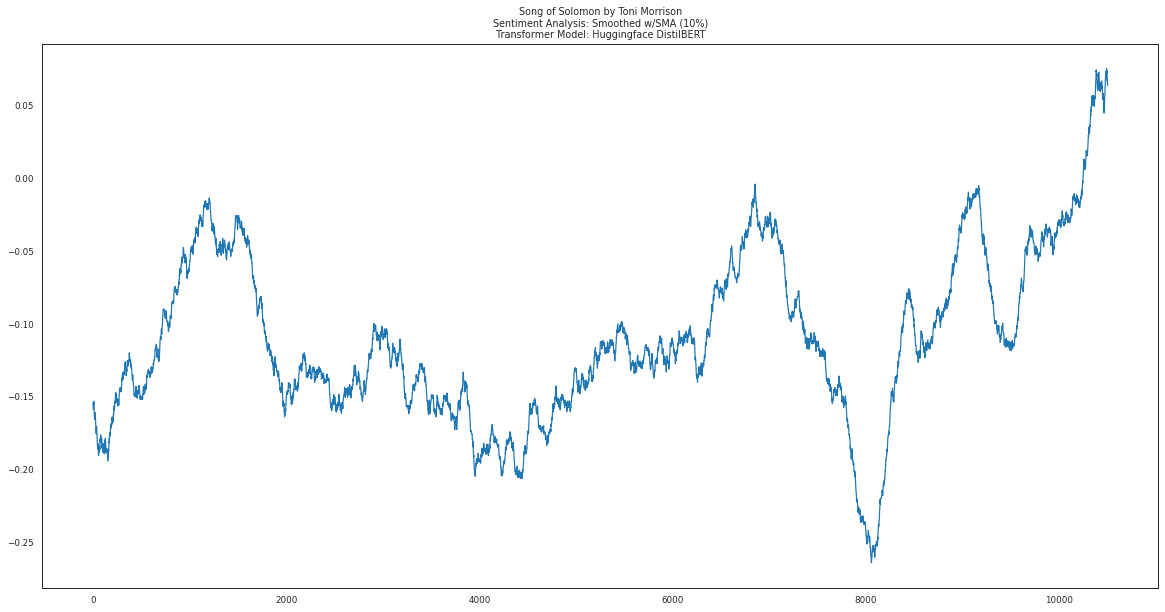

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_titles_ls[novel_indx]
# amodel_str = 'huggingface' 
win_aper = 10

win_10per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][novel_indx]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.show();

In [ ]:
# [SKIP]

In [ ]:
# Define Model and Test

model_title = 'Yelp BERT'
model_name = 'yelp'
model_type = 'Transformer'

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(test_words_ls):

  aword_enc = tokenizer(aword_str, return_tensors='pt')
  logits_tensor = sa_yelp(**aword_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Word: {aword_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(test_sentences_ls):

  asent_enc = tokenizer(asent_str, return_tensors='pt')
  logits_tensor = sa_yelp(**asent_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Sentence: {aword_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

In [ ]:
# Verify saving results to correct model name

print(f'Saving results to Model: {model_name}')

sent_test_str = "I hate Mondays and bad doctors."
print(f"Sentence: {sent_test_str}\n {logitstensor2sentiment(sa_hinglish(**tokenizer(sent_test_str, return_tensors='pt')))[0]}")

In [ ]:
%%time

# NOTE:    10m45s @17:39 on 20220301 Colab Pro P100 (1 Novel: cmieville_thecityandthecity: 10.1k sentences)
#          10m19s @17:48 on 20220301 Colab Pro P100 (1 Novel: scollins_thehungergames1: 9.0k sentences)

# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  models_ls = corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: logitstensor2sentiment(sa_yelp(**tokenizer(x, return_tensors='pt')))[0])
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

In [ ]:
%%time
"""
# NOTE:    10m45s @17:39 on 20220301 Colab Pro P100 (1 Novel: cmieville_thecityandthecity: 10.1k sentences)
#          10m19s @17:48 on 20220301 Colab Pro P100 (1 Novel: scollins_thehungergames1: 9.0k sentences)

# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  print(f"Processing #{i}: {atext}")

  corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].progress_apply(lambda x: logitstensor2sentiment(sa_yelp(**tokenizer(x, return_tensors='pt')))[0])
""";

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 1
text_title_str = corpus_titles_ls[novel_indx]

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {model_title}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory
os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_huggingface.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_reference_transformer_huggingface.json'

write_dict_dfs(global_vars.corpus_texts_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}')



Currently in SentimentArcs root directory:
/gdrive/MyDrive/sentimentarcs_notebooks
Saving Text_Type: novels
     Corpus_Type: new

These Text Titles:



dict_keys(['tmorrison_songofsolomon', 'cliu_threebodyproblem', 'sking_doctorsleep'])


To This Subdirectory:



'./sentiment_raw/sentiment_raw_novels_new_corpus2/'

Saving file to: ./sentiment_raw/sentiment_raw_novels_new_corpus2/sentiment_raw_novels_new_corpus2_transformer_huggingface.json


In [ ]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

total 24854
-rw------- 1 root root       0 Apr 10 17:52 test.txt
-rw------- 1 root root 8483161 Apr 12 13:55 all_novels_new_huggingface.json
-rw------- 1 root root 8483161 Apr 12 13:59 sentiment_raw_novels_new_corpus2_transformer_huggingface.json
-rw------- 1 root root 8483026 Apr 12 14:01 sentiment_raw_novels_new_corpus_2_transformer_roberta.json


In [ ]:
# [SKIP]

In [ ]:
# Verify in SentimentArcs Root Directory

os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
!pwd

In [ ]:
# Save sentiment values to subdir_sentiments
# save_filename = f'sentiment_raw_{Corpus_Type}_{Text_Type}_dnn2transformer.json'
write_dict_dfs(corpus_texts_dt, out_file=FNAME_SENTIMENT_RAW, out_dir=SUBDIR_SENTIMENT_RAW)
print(f'Saving Text_Type: {Text_Type}')
print(f'     Corpus_Type: {Corpus_Type}')
print('\n')

# Verify Dictionary was saved correctly by reading back the *.json datafile
test_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
print(f'These Text Titles:')
test_dt.keys()
print('\n')

corpus_texts_dt[corpus_titles_ls[0]].head()
print('\n')

test_dt[novels_titles_ls[0]].info()


## **Hinglish Mixed Code BERT (3 cats)**

* https://huggingface.co/rohanrajpal/bert-base-multilingual-codemixed-cased-sentiment

In [ ]:
# Hindi-English Code Switching BERT Model

# from transformers import AutoTokenizer, AutoModelForSequenceClassification (above)
tokenizer = AutoTokenizer.from_pretrained("rohanrajpal/bert-base-multilingual-codemixed-cased-sentiment")

sa_hinglish = AutoModelForSequenceClassification.from_pretrained("rohanrajpal/bert-base-multilingual-codemixed-cased-sentiment")

In [ ]:
# Test

text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_hinglish(**text_enc)
print(f'Hinglish SA Model:\n  INPUT: {text_str}\n  SENTIMENT: {text_sentiment}')
print(f'  TYPE: {type(text_sentiment)}')
text_smax_ls_ls = text_sentiment.logits.softmax(dim=-1).tolist()
text_smax_ls = text_smax_ls_ls[0]
print(type(text_smax_ls[0]))
print(f'  sMAX: {text_smax_ls}')
max_val = max(text_smax_ls)
max_indx = text_smax_ls.index(max_val)
print(f'   MAX: {max_val} at indx={max_indx}')

In [ ]:
"""
def logitstensor2sentiment(hugseqclass_output):
  '''
  Given a Huggingface SequenceClassifierOutput logits tensor
  Return Sentiment and assoc softmax probability values
  '''

  text_smax_ls_ls = hugseqclass_output.logits.softmax(dim=-1).tolist()
  text_smax_ls = text_smax_ls_ls[0]
  # print(type(text_smax_ls[0]))
  # print(f'  sMAX: {text_smax_ls}')
  max_val = max(text_smax_ls)            # Probability based upon logits %
  max_indx = text_smax_ls.index(max_val) # Sentiment (starting from 0 up)
  val_scale = len(text_smax_ls)
  # print(f'   MAX: {max_val} at indx={max_indx}')

  return max_indx, val_scale, max_val
""";

# Test
text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_hinglish(**text_enc)

sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(text_sentiment)
print(f'SENTENCE: {text_str}')
print(f'          Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})')

In [ ]:
# Define Model and Test

model_title = 'Hinglish Dual Code BERT'
model_name = 'hinglish'
model_type = 'Transformer'

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(test_words_ls):

  aword_enc = tokenizer(aword_str, return_tensors='pt')
  logits_tensor = sa_hinglish(**aword_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Word: {aword_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(test_sentences_ls):

  asent_enc = tokenizer(asent_str, return_tensors='pt')
  logits_tensor = sa_hinglish(**asent_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Sentence: {aword_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

In [ ]:
# Verify saving results to correct model name

print(f'Saving results to Model: {model_name}')

sent_test_str = "I hate Mondays and bad doctors."
print(f"Sentence: {sent_test_str}\n {logitstensor2sentiment(sa_hinglish(**tokenizer(sent_test_str, return_tensors='pt')))[0]}")

In [ ]:
%%time

# NOTE:    8m06s @17:39 on 20220301 Colab Pro P100 (1 Novel: cmieville_thecityandthecity: 10.1k sentences)
#         10m00s @17:48 on 20220301 Colab Pro P100 (1 Novel: scollins_thehungergames1: 9.0k sentences)

# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  models_ls = corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: logitstensor2sentiment(sa_hinglish(**tokenizer(x, return_tensors='pt')))[0])
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

In [ ]:
%%time
"""
# NOTE:    8m06s @17:39 on 20220301 Colab Pro P100 (1 Novel: cmieville_thecityandthecity: 10.1k sentences)
#         10m00s @17:48 on 20220301 Colab Pro P100 (1 Novel: scollins_thehungergames1: 9.0k sentences)

# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  print(f"Processing #{i}: {atext}")

  corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].progress_apply(lambda x: logitstensor2sentiment(sa_hinglish(**tokenizer(x, return_tensors='pt')))[0])
""";

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 1
text_title_str = corpus_titles_ls[novel_indx]

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {model_title}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory

os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
!pwd

In [ ]:
# Save sentiment values to subdir_sentiments
# save_filename = f'sentiment_raw_{Corpus_Type}_{Text_Type}_dnn2transformer.json'
write_dict_dfs(corpus_texts_dt, out_file=FNAME_SENTIMENT_RAW, out_dir=SUBDIR_SENTIMENT_RAW)
print(f'Saving Text_Type: {Text_Type}')
print(f'     Corpus_Type: {Corpus_Type}')
print('\n')

# Verify Dictionary was saved correctly by reading back the *.json datafile
test_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
print(f'These Text Titles:')
test_dt.keys()
print('\n')

corpus_texts_dt[corpus_titles_ls[0]].head()
print('\n')

test_dt[novels_titles_ls[0]].info()


## **BERT IMDB Sentiment (2 cats)**

* https://huggingface.co/abhishek/autonlp-imdb_sentiment_classification-31154 (metrics)

In [ ]:
# BERT Sentiment Classifier fine-tuned on IMDB

# from transformers import AutoTokenizer, AutoModelForSequenceClassification (above)
tokenizer = AutoTokenizer.from_pretrained("abhishek/autonlp-imdb_sentiment_classification-31154")

sa_imdb = AutoModelForSequenceClassification.from_pretrained("abhishek/autonlp-imdb_sentiment_classification-31154")

Downloading:   0%|          | 0.00/283 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/816 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/313M [00:00<?, ?B/s]

In [ ]:
# sentiment_analysis = pipeline("sentiment-analysis",model="abhishek/autonlp-imdb_sentiment_classification-31154")

In [ ]:
# Test

text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_imdb(**text_enc)
print(f'IMDB SA Model:\n  INPUT: {text_str}\n  SENTIMENT: {text_sentiment}')
print(f'  TYPE: {type(text_sentiment)}')
text_smax_ls_ls = text_sentiment.logits.softmax(dim=-1).tolist()
text_smax_ls = text_smax_ls_ls[0]
print(type(text_smax_ls[0]))
print(f'  sMAX: {text_smax_ls}')
max_val = max(text_smax_ls)
max_indx = text_smax_ls.index(max_val)
print(f'   MAX: {max_val} at indx={max_indx}')

In [ ]:
"""
def logitstensor2sentiment(hugseqclass_output):
  '''
  Given a Huggingface SequenceClassifierOutput logits tensor
  Return Sentiment and assoc softmax probability values
  '''

  text_smax_ls_ls = hugseqclass_output.logits.softmax(dim=-1).tolist()
  text_smax_ls = text_smax_ls_ls[0]
  # print(type(text_smax_ls[0]))
  # print(f'  sMAX: {text_smax_ls}')
  max_val = max(text_smax_ls)            # Probability based upon logits %
  max_indx = text_smax_ls.index(max_val) # Sentiment (starting from 0 up)
  val_scale = len(text_smax_ls)
  # print(f'   MAX: {max_val} at indx={max_indx}')

  return max_indx, val_scale, max_val
""";

# Test
text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_imdb(**text_enc)

sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(text_sentiment)
print(f'SENTENCE: {text_str}')
print(f'          Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})')

In [ ]:
# Define Model and Test

model_title = 'IMDB BERT'
model_name = 'imdb2way'
model_type = 'Transformer'

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(test_words_ls):
  
  aword_enc = tokenizer(aword_str, return_tensors='pt')
  logits_tensor = sa_imdb(**aword_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Word: {aword_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(test_sentences_ls):

  asent_enc = tokenizer(asent_str, return_tensors='pt')
  logits_tensor = sa_imdb(**asent_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Sentence: {aword_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

Emoji String: We are very happy to show you the 🤗 Transformers library.
    Sentiment: 1 out of 2 (prob=0.996)




Testing WORD Sentiment
--------------------------------------------------
Word: Love
    Sentiment: 1 out of 2 (prob=0.930)

Word: Hate
    Sentiment: 0 out of 2 (prob=0.734)

Word: bizarre
    Sentiment: 0 out of 2 (prob=0.999)

Word: strange
    Sentiment: 1 out of 2 (prob=0.966)

Word: furious
    Sentiment: 1 out of 2 (prob=0.996)

Word: elated
    Sentiment: 0 out of 2 (prob=0.995)

Word: curious
    Sentiment: 1 out of 2 (prob=0.997)

Word: beserk
    Sentiment: 1 out of 2 (prob=0.782)

Word: gambaro
    Sentiment: 1 out of 2 (prob=0.941)


Testing SENTENCE Sentiment
--------------------------------------------------
Word: I hate bad evil worthless Mondays.
    Sentiment: 0 out of 2 (prob=0.998)

Word: I love Paris in the springtime
    Sentiment: 1 out of 2 (prob=0.997)

Word: It was Wednesday.
    Sentiment: 1 out of 2 (prob=0.979)

Word: You are a disgusting pig -

In [ ]:
# Verify saving results to correct model name

print(f'Saving results to Model: {model_name}')

sent_test_str = "I hate Mondays and bad doctors."
print(f"Sentence: {sent_test_str}\n {logitstensor2sentiment(sa_imdb(**tokenizer(sent_test_str, return_tensors='pt')))[0]}")

In [ ]:
%%time

# NOTE:     4m32s @18:10 on 20220301 Colab Pro P100 (1 Novel: cmieville_thecityandthecity: 10.1k sentences)
#           4m08s @18:15 on 20220301 Colab Pro P100 (1 Novel: scollins_thehungergames1: 9.0k sentences)

# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  models_ls = corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: logitstensor2sentiment(sa_imdb(**tokenizer(x, return_tensors='pt')))[0])
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

In [ ]:
%%time
"""
# NOTE:     4m32s @18:10 on 20220301 Colab Pro P100 (1 Novel: cmieville_thecityandthecity: 10.1k sentences)
#           4m08s @18:15 on 20220301 Colab Pro P100 (1 Novel: scollins_thehungergames1: 9.0k sentences)

# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  print(f"Processing #{i}: {atext}")

  corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].progress_apply(lambda x: logitstensor2sentiment(sa_imdb(**tokenizer(x, return_tensors='pt')))[0])
""";

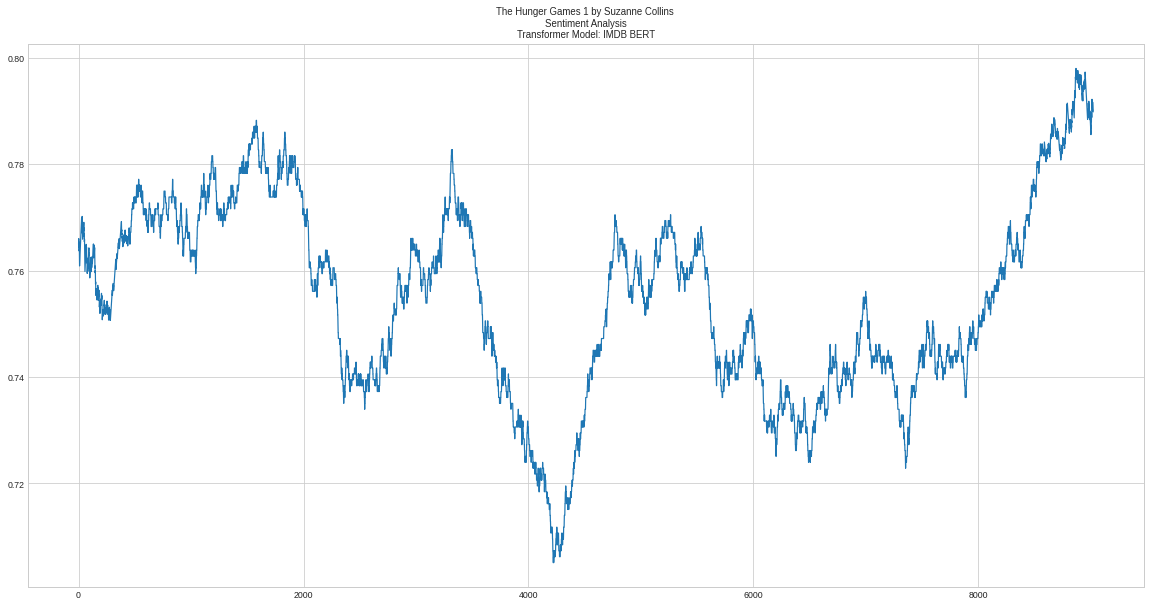

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 1
text_title_str = corpus_titles_ls[novel_indx]

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {model_title}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory

os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
!pwd

In [ ]:
# Save sentiment values to subdir_sentiments
# save_filename = f'sentiment_raw_{Corpus_Type}_{Text_Type}_dnn2transformer.json'
write_dict_dfs(corpus_texts_dt, out_file=FNAME_SENTIMENT_RAW, out_dir=SUBDIR_SENTIMENT_RAW)
print(f'Saving Text_Type: {Text_Type}')
print(f'     Corpus_Type: {Corpus_Type}')
print('\n')

# Verify Dictionary was saved correctly by reading back the *.json datafile
test_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
print(f'These Text Titles:')
test_dt.keys()
print('\n')

corpus_texts_dt[corpus_titles_ls[0]].head()
print('\n')

test_dt[novels_titles_ls[0]].info()


## **T5Base 50k Finetuned IMDB Sentiment Extraction (2 cats)**

* https://huggingface.co/mrm8488/t5-small-finetuned-imdb-sentiment 
* https://github.com/patil-suraj/exploring-T5/blob/master/t5_fine_tuning.ipynb

In [ ]:
from transformers import AutoTokenizer, AutoModelWithLMHead

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-small-finetuned-imdb-sentiment")

model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-small-finetuned-imdb-sentiment")

def sa_t5imdb50k(text):
  input_ids = tokenizer.encode(text + '</s>', return_tensors='pt')

  output = model.generate(input_ids=input_ids,
               max_length=2)
  
  dec = [tokenizer.decode(ids) for ids in output]
  label = dec[0]
  return label
  
sa_t5imdb50k("I dislike a lot that film")

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

'<pad> negative'

In [ ]:
# Test

text_str = "I love sunny days and happy puppy dogs."
res = sa_t5imdb50k(text_str)
type(res)
print(f'res: [{res}]')


str

res: [<pad> positive]


In [ ]:
def t5str2sentiment(t5_str):
  '''
  Given a T5 text string with sentiment and tags
  Return a -1,0,1 for negative,neutral/OOV,positive sentiment
  '''

  t5_sentiment1_str = t5_str.replace('<pad>','')
  t5_sentiment2_str = t5_sentiment1_str.replace('</s>','')
  t5_core_str = t5_sentiment2_str.strip().lower()
  # print(f't5_sentiment_raw_str: {t5_sentiment_raw_str}')
  # print(f't5_sentiment_str: {t5_sentiment_str}')
  # print(f't5_core_str: {t5_core_str}')
  if t5_core_str == 'positive':
    t5_sentiment_fl = 1
  elif t5_core_str == 'negative':
    t5_sentiment_fl = -1
  elif len(t5_core_str) > 0:
    # Out of Vocab (OOV) Word
    t5_sentiment_fl = 0
  elif len(t5_core_str) == 0:
    # Empty String
    t5_sentiment_fl = 0
  else:
    print(f'ERROR: Illegal value ts_sentiment_str: {t5_sentiment_str}')

  return int(t5_sentiment_fl)

# Test
asent_str = "I love the good and kind-hearted lovely lady who give me tasty cookies."
t5_response_str = sa_t5imdb50k(asent_str)
asentiment_int = t5str2sentiment(t5_response_str)
print(f'STRING: {asent_str}\nSENTIMENT: {asentiment_int}')

STRING: I love the good and kind-hearted lovely lady who give me tasty cookies.
SENTIMENT: 1


In [ ]:
# Define Model and Test

model_title = 'T5 Base IMDB50K'
model_name = 't5imdb50k'
model_type = 'Transformer'

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(test_words_ls):

  t5_sentiment_raw_str = t5str2sentiment(sa_t5imdb50k(aword_str))
  print(f'Word: {aword_str}\n    Sentiment: {t5_sentiment_raw_str}\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(test_sentences_ls):

  t5_sentiment_raw_str = t5str2sentiment(sa_t5imdb50k(asent_str))
  print(f'Word: {asent_str}\n    Sentiment: {t5_sentiment_raw_str}\n')

Testing WORD Sentiment
--------------------------------------------------
Word: Love
    Sentiment: 1

Word: Hate
    Sentiment: -1

Word: bizarre
    Sentiment: 0

Word: strange
    Sentiment: -1

Word: furious
    Sentiment: 0

Word: elated
    Sentiment: -1

Word: curious
    Sentiment: 1

Word: beserk
    Sentiment: -1

Word: gambaro
    Sentiment: -1


Testing SENTENCE Sentiment
--------------------------------------------------
Word: I hate bad evil worthless Mondays.
    Sentiment: -1

Word: I love Paris in the springtime
    Sentiment: 1

Word: It was Wednesday.
    Sentiment: 1

Word: You are a disgusting pig - I hate you.
    Sentiment: -1

Word: What a delightfully funny and beautiful good man.
    Sentiment: 1

Word: That was it
    Sentiment: 0



In [ ]:
# Verify saving results to correct model name

print(f'Saving results to Model: {model_name}\n')

sent_test_str = "I hate Mondays and bad doctors."
# sent_test_str = "You are a disgusting pig - I hate you."
print(f"SENTENCE: {sent_test_str}\nSENTIMENT: {t5str2sentiment(sa_t5imdb50k(sent_test_str))}")

Saving results to Model: t5imdb50k

SENTENCE: I hate Mondays and bad doctors.
SENTIMENT: -1


In [ ]:
%%time

# NOTE:    10m45s @17:39 on 20220301 Colab Pro (1 Novel: cmieville_thecityandthecity: 10.1k sentences)
#          10m00s @17:48 on 20220301 Colab Pro (1 Novel: scollins_thehungergames1: 9.0k sentences)

# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  models_ls = corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: t5str2sentiment(sa_t5imdb50k(x)))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

In [ ]:
%%time
"""
# NOTE:    10m45s @17:39 on 20220301 Colab Pro (1 Novel: cmieville_thecityandthecity: 10.1k sentences)
#          10m00s @17:48 on 20220301 Colab Pro (1 Novel: scollins_thehungergames1: 9.0k sentences)

# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  print(f"Processing #{i}: {atext}")

  corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].progress_apply(lambda x: t5str2sentiment(sa_t5imdb50k(x)))
""";

Processing #0: cmieville_thecityandthecity


  0%|          | 0/10125 [00:00<?, ?it/s]

Processing #1: scollins_thehungergames1


  0%|          | 0/9021 [00:00<?, ?it/s]

CPU times: user 17min 37s, sys: 9.48 s, total: 17min 47s
Wall time: 8min 52s


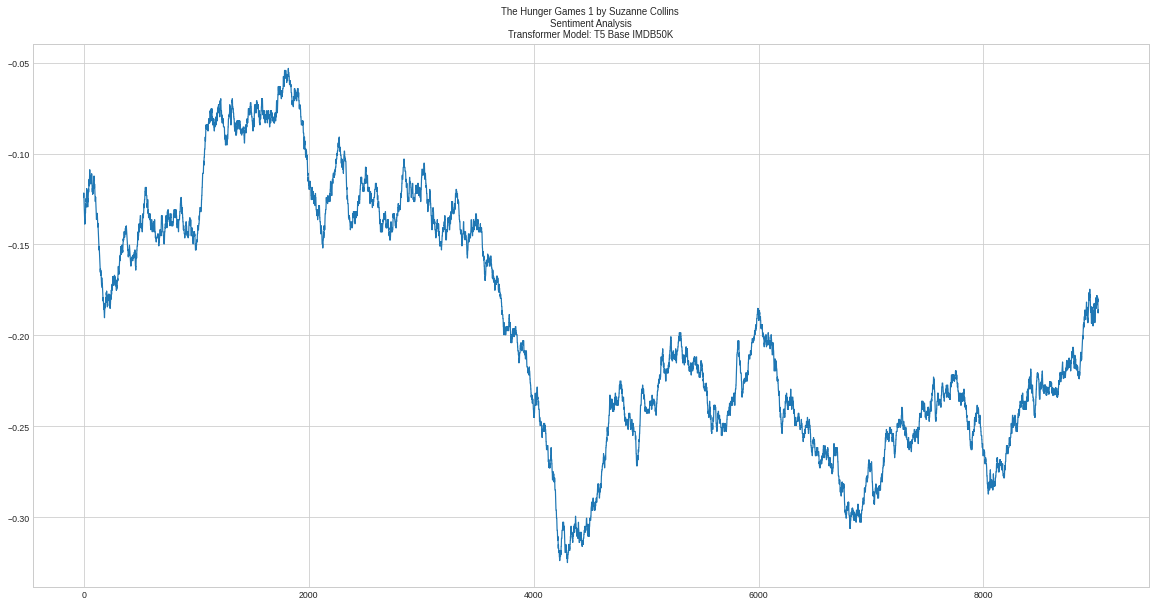

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 1
text_title_str = corpus_titles_ls[novel_indx]

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {model_title}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory

os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
!pwd

/gdrive/MyDrive/cdh/sentiment_arcs


In [ ]:
# Save sentiment values to subdir_sentiments
# save_filename = f'sentiment_raw_{Corpus_Type}_{Text_Type}_dnn2transformer.json'
write_dict_dfs(corpus_texts_dt, out_file=FNAME_SENTIMENT_RAW, out_dir=SUBDIR_SENTIMENT_RAW)
print(f'Saving Text_Type: {Text_Type}')
print(f'     Corpus_Type: {Corpus_Type}')
print('\n')

# Verify Dictionary was saved correctly by reading back the *.json datafile
test_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
print(f'These Text Titles:')
test_dt.keys()
print('\n')

corpus_texts_dt[corpus_titles_ls[0]].head()
print('\n')

test_dt[novels_titles_ls[0]].info()


Saving file to: ./sentiment_raw/novels_sentiment_new_raw/sentiment_raw_novels_new_dnn2transformer.json
Saving Text_Type: novels
     Corpus_Type: new


These Text Titles:


dict_keys(['cmieville_thecityandthecity', 'scollins_thehungergames1'])

,hinglish,huggingface,imdb2way,nlptown,roberta15lg,robertaxml8lang,text_clean,text_raw,yelp,t5imdb50k
0,0,-0.936181,1,2.264484,-0.963685,0.000000,annotation,Annotation,2,1
1,0,0.739575,1,3.329419,-0.997429,-0.660563,the city be beszel a rundown metropolis on the eastern edge of europe,"The city is Beszel, a rundown metropolis on the eastern edge of Europe.",1,-1
2,2,0.970969,1,2.346609,0.997683,-0.537102,the other city be ul qoma a modern eastern european boomtown despite be a bite of a internationa...,"The other city is Ul Qoma, a modern Eastern European boomtown, despite being a bit of an interna...",4,-1
3,2,0.998701,1,3.328189,0.998308,0.417663,what the two city share and what they do not be the deliciously evocative conundrum at the heart...,"What the two cities share, and what they don't, is the deliciously evocative conundrum at the he...",2,1
4,2,0.998341,1,3.306802,0.998878,0.427551,mieville be good know a a modern fantasist and urbanist but from book to book he be try on diffe...,"Mieville is well known as a modern fantasist (and urbanist), but from book to book he's tried on...",4,1




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10125 entries, 0 to 10124
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   hinglish         10125 non-null  int64  
 1   huggingface      10125 non-null  float64
 2   imdb2way         10125 non-null  int64  
 3   nlptown          10125 non-null  float64
 4   roberta15lg      10125 non-null  float64
 5   robertaxml8lang  10125 non-null  float64
 6   t5imdb50k        10125 non-null  int64  
 7   text_clean       10125 non-null  object 
 8   text_raw         10125 non-null  object 
 9   yelp             10125 non-null  int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 791.1+ KB


## **RoBERTa XLM Twitter 8 Multilingual (3 cats, slow)**

* http://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment

In [ ]:
# !pip install sentencepiece

In [ ]:
# RoBERTa XLM Fine-tuend on 8 Multilingual Tweets

model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sa_robertaxml8lang = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

# Test
sa_robertaxml8lang("T'estimo!")

[{'label': 'Positive', 'score': 0.6600582599639893}]

In [ ]:
# Define Model and Test

model_title = 'RoBERTa XLM Twitter 8Lang'
model_name = 'robertaxml8lang'
model_type = 'Transformer'

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(test_words_ls):

  word_sentiment_fl = sa_robertaxml8lang(aword_str)
  print(f'Word: {aword_str}\n    {word_sentiment_fl}\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(test_sentences_ls):

  sent_sentiment_fl = labelscore2fl(sa_robertaxml8lang(asent_str), sa_model=sa_robertaxml8lang)
  print(f'Sentence: {asent_str}\n    {sent_sentiment_fl:.3f}\n')

Testing WORD Sentiment
--------------------------------------------------
Word: Love
    [{'label': 'Positive', 'score': 0.39642244577407837}]

Word: Hate
    [{'label': 'Negative', 'score': 0.5858045816421509}]

Word: bizarre
    [{'label': 'Negative', 'score': 0.4368371367454529}]

Word: strange
    [{'label': 'Negative', 'score': 0.3701768219470978}]

Word: furious
    [{'label': 'Negative', 'score': 0.42496591806411743}]

Word: elated
    [{'label': 'Neutral', 'score': 0.38555991649627686}]

Word: curious
    [{'label': 'Neutral', 'score': 0.49868252873420715}]

Word: beserk
    [{'label': 'Negative', 'score': 0.36750832200050354}]

Word: gambaro
    [{'label': 'Neutral', 'score': 0.3720065653324127}]


Testing SENTENCE Sentiment
--------------------------------------------------
Sentence: I hate bad evil worthless Mondays.
    -0.955

Sentence: I love Paris in the springtime
    0.846

Sentence: It was Wednesday.
    0.000

Sentence: You are a disgusting pig - I hate you.
    -0.9

In [ ]:
# Verify saving results to correct model name

print(f'Saving results to Model: {model_name}')

Saving results to Model: robertaxml8lang


In [ ]:
%%time

# NOTE:   9m05s @16:40 on 20220301 Colab Pro P100 (1 Novel: cmieville_thecityandthecity)
#         ~8m07s @16:49 on 20220201 Colab Pro P100 (1 Novel: scollins_thehungergames1)

# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  models_ls = corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: labelscore2fl(sa_robertaxml8lang(x), sa_model=sa_robertaxml8lang))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

In [ ]:
%%time
"""
# NOTE:   9m05s @16:40 on 20220301 Colab Pro P100 (1 Novel: cmieville_thecityandthecity)
#         ~8m07s @16:49 on 20220201 Colab Pro P100 (1 Novel: scollins_thehungergames1)

# Compute Sentiments based upon SentimentR Lexicon

for i, atext in enumerate(corpus_texts_dt.keys()):
  print(f"Processing #{i}: {atext}")

  corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].progress_apply(lambda x: labelscore2fl(sa_robertaxml8lang(x), sa_model=sa_robertaxml8lang))
""";

Processing #0: cmieville_thecityandthecity


  0%|          | 0/10125 [00:00<?, ?it/s]

Processing #1: scollins_thehungergames1


  0%|          | 0/9021 [00:00<?, ?it/s]

CPU times: user 33min 28s, sys: 11.5 s, total: 33min 40s
Wall time: 16min 50s


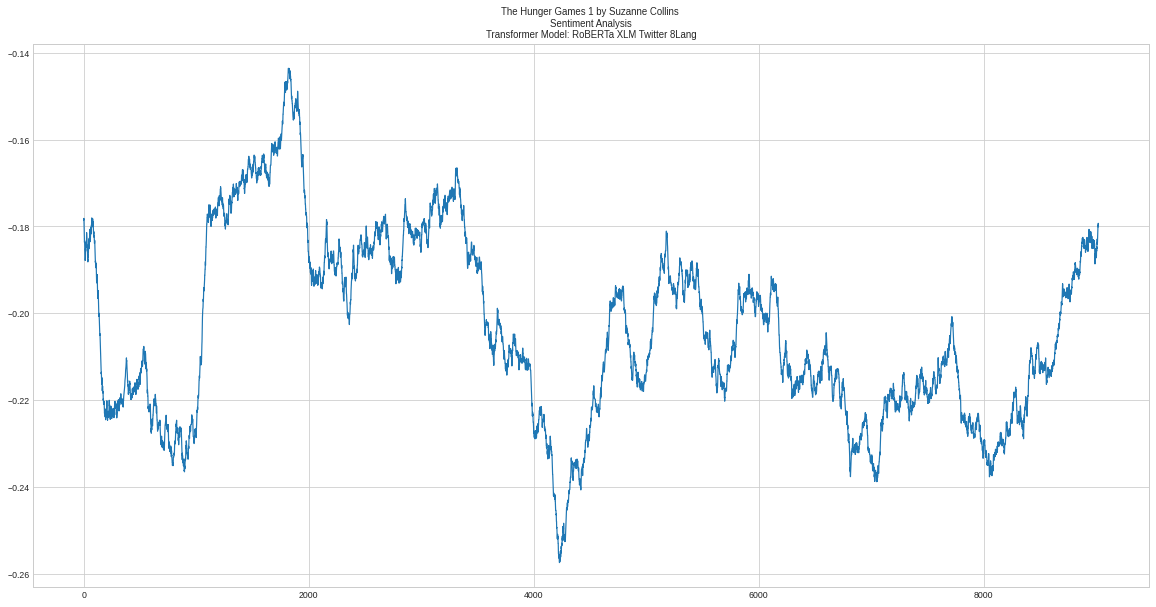

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 1
text_title_str = corpus_titles_ls[novel_indx]

win_10per = int(0.10*corpus_texts_dt[text_title_str].shape[0])
plot_title_str = f"{corpus_titles_dt[text_title_str][0]}\nSentiment Analysis\n{model_type} Model: {model_title}"
corpus_texts_dt[text_title_str][model_name].rolling(win_10per, center=True, min_periods=0).mean().plot(title=plot_title_str)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory

os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
!pwd

/gdrive/MyDrive/cdh/sentiment_arcs


In [ ]:
# Save sentiment values to subdir_sentiments
# save_filename = f'sentiment_raw_{Corpus_Type}_{Text_Type}_dnn2transformer.json'
write_dict_dfs(corpus_texts_dt, out_file=FNAME_SENTIMENT_RAW, out_dir=SUBDIR_SENTIMENT_RAW)
print(f'Saving Text_Type: {Text_Type}')
print(f'     Corpus_Type: {Corpus_Type}')
print('\n')

# Verify Dictionary was saved correctly by reading back the *.json datafile
test_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
print(f'These Text Titles:')
test_dt.keys()
print('\n')

corpus_texts_dt[corpus_titles_ls[0]].head()
print('\n')

test_dt[novels_titles_ls[0]].info()

Saving file to: ./sentiment_raw/novels_sentiment_new_raw/sentiment_raw_novels_new_dnn2transformer.json
Saving Text_Type: novels
     Corpus_Type: new


These Text Titles:


dict_keys(['cmieville_thecityandthecity', 'scollins_thehungergames1'])

,hinglish,huggingface,imdb2way,nlptown,roberta15lg,text_clean,text_raw,yelp,robertaxml8lang
0,0,-0.936181,1,2.264484,-0.963685,annotation,Annotation,2,0.000000
1,0,0.739575,1,3.329419,-0.997429,the city be beszel a rundown metropolis on the eastern edge of europe,"The city is Beszel, a rundown metropolis on the eastern edge of Europe.",1,-0.660563
2,2,0.970969,1,2.346609,0.997683,the other city be ul qoma a modern eastern european boomtown despite be a bite of a internationa...,"The other city is Ul Qoma, a modern Eastern European boomtown, despite being a bit of an interna...",4,-0.537102
3,2,0.998701,1,3.328189,0.998308,what the two city share and what they do not be the deliciously evocative conundrum at the heart...,"What the two cities share, and what they don't, is the deliciously evocative conundrum at the he...",2,0.417663
4,2,0.998341,1,3.306802,0.998878,mieville be good know a a modern fantasist and urbanist but from book to book he be try on diffe...,"Mieville is well known as a modern fantasist (and urbanist), but from book to book he's tried on...",4,0.427551




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10125 entries, 0 to 10124
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   hinglish         10125 non-null  int64  
 1   huggingface      10125 non-null  float64
 2   imdb2way         10125 non-null  int64  
 3   nlptown          10125 non-null  float64
 4   roberta15lg      10125 non-null  float64
 5   robertaxml8lang  10125 non-null  float64
 6   text_clean       10125 non-null  object 
 7   text_raw         10125 non-null  object 
 8   yelp             10125 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 712.0+ KB


In [ ]:
corpus_texts_dt[corpus_titles_ls[0]].info()

NameError: ignored

# **END OF NOTEBOOK**